In [1]:
import pandas as pd
import numpy as np
import random
import math
from collections import Counter
import copy
import matplotlib.pyplot as plt

In [2]:
dmahasiswa = pd.read_csv('mahasiswa.csv')
dasrama    = pd.read_csv('asrama.csv')

# Preprocessing Dataset

## A. Persiapan Data Mahasiwa

### 1. Memberikan id untuk setiap mahasiswa dan melakukan transformasi data

In [3]:
def preprocessing_data_mahasiswa(data_mahasiswa):
    # membuat sebuah kolom baru dengan nama "unique_id" yang berisi id mahasiswa
    data_mahasiswa['id_mahasiswa'] = data_mahasiswa.index
    data_mahasiswa['id_mahasiswa'] = data_mahasiswa['id_mahasiswa'].apply(lambda x: "idM_" + str(x))

    # mengubah nama kolom dan melakukan transformasi data
    data_mahasiswa = data_mahasiswa.rename(columns = {'Program Studi' : 'Prodi'})
    data_mahasiswa = data_mahasiswa.rename(columns = {'Jenis Kelamin' : 'Gender'})

    prodi_map = {
        'S1 Informatika': 'if',
        'S1 Sistem Informasi': 'si',
        'S1 Manajemen Rekayasa': 'mr',
        'S1 Teknik Bioproses': 'bp',
        'S1 Teknik Elektro': 'te',
        'DIV Teknologi Rekayasa Perangkat Lunak': 'trpl',
        'DIII Teknologi Informasi': 'ti',
        'DIII Teknologi Komputer': 'tk'
    }
    data_mahasiswa['Prodi'] = data_mahasiswa['Prodi'].map(prodi_map)

    angkatan_map = {
        2017 : 17,
        2018 : 18,
        2019 : 19,
        2020 : 20,
        2021 : 21,
        2022 : 22
    }
    data_mahasiswa['Angkatan'] = data_mahasiswa['Angkatan'].map(angkatan_map)

    gender_map = {
        'L' : 'aspa',
        'P' : 'aspi'
    }
    data_mahasiswa['Gender'] = data_mahasiswa['Gender'].map(gender_map)

    prodi = list(set((data_mahasiswa['Prodi'])))
    angkatan = list(set((data_mahasiswa['Angkatan'])))
    gender = list(set((data_mahasiswa['Gender'])))

    return data_mahasiswa

### 2. Membuat list yang membagi data mahasiswa berdasarkan prodi, angkatan dan gender

In [4]:
def bagi_mahasiswa(data_mahasiswa):
    # mendaftarkan prodi, angkatan dan gender unik di dalam data mahasiswa
    prodi = list(set((data_mahasiswa['Prodi'])))
    angkatan = list(set((data_mahasiswa['Angkatan'])))
    gender = list(set((data_mahasiswa['Gender'])))

    mahasiswa_it_del = {}

    # pembentukan list baru yang akan membagi mahasiswa berdasarkan prodi, angkatan dan jenis kelamin
    for p in prodi:
        for a in angkatan:
            for g in gender:
                mahasiswa_it_del[f'{g}_{p}_{a}'] = data_mahasiswa[(data_mahasiswa['Prodi'] == p) &
                                                             (data_mahasiswa['Angkatan'] == a) &
                                                             (data_mahasiswa['Gender'] == g)]
    # melakukan pengecekan dan penghapusan list prodi yang kosong
    empty_dictionary = []
    for mahasiswa in mahasiswa_it_del:
        jumlah = len(mahasiswa_it_del[mahasiswa])
        if jumlah == 0 :
            empty_dictionary.append(mahasiswa)

    for mahasiswa in empty_dictionary:
        del mahasiswa_it_del[mahasiswa]

    return mahasiswa_it_del

## B. Persiapan data asrama

In [5]:
def preprocessing_data_asrama(data_asrama):
    # mengubah nama kolom dan melakukan transformasi data
    data_asrama = data_asrama.rename(columns = {'Nama Asrama' : 'asrama'})
    data_asrama = data_asrama.rename(columns = {'Jumlah Mahasiswa per Kamar' : 'perkamar'})
    data_asrama = data_asrama.rename(columns = {'Jumlah Lantai' : 'lantai'})
    data_asrama = data_asrama.rename(columns = {'Lantai 1' : 'l1'})
    data_asrama = data_asrama.rename(columns = {'Lantai 2' : 'l2'})
    data_asrama = data_asrama.rename(columns = {'Lantai 3' : 'l3'})
    data_asrama = data_asrama.rename(columns = {'Lantai 4' : 'l4'})
    data_asrama = data_asrama.rename(columns = {'Jumlah Kamar' : 'kamar'})
    data_asrama = data_asrama.rename(columns = {'Kapasitas Mahasiswa' : 'kapasitas'})
    data_asrama = data_asrama.rename(columns = {'Yang Menempati' : 'menempati'})

    asrama_map = {
        'Asrama Basket': 'pniel',
        'Asrama Danau Toba': 'antiokia',
        'Asrama Kembar 1': 'kapernaum',
        'Asrama Kembar 2': 'silo',
        'Rusun 1': 'mambre',
        'Rusun 2': 'mahanaim',
        'Rusun 3': 'nazareth',
        'Rusun 4': 'kana'
    }

    menempati_map = {
        'L': 'aspa',
        'P': 'aspi'
    }

    data_asrama['asrama'] = data_asrama['asrama'].map(asrama_map)
    data_asrama['menempati'] = data_asrama['menempati'].map(menempati_map)

    # membuat kolom baru untuk meyimpan data dari kolom l1, l2, l3 dan l4, serta menghapus kolom l1, l2, l3 dan l4
    data_asrama['l1'] = data_asrama['l1'].astype(str)
    data_asrama['l2'] = data_asrama['l2'].astype(str)
    data_asrama['l3'] = data_asrama['l3'].astype(str)
    data_asrama['l4'] = data_asrama['l4'].astype(str)

    data_asrama['kamar_per_lantai'] = data_asrama.apply(lambda x: [int(x['l1']), int(x['l2']), int(x['l3']), int(x['l4'])], axis=1)
    data_asrama = data_asrama.drop(columns=['l1', 'l2', 'l3', 'l4'])

    return data_asrama

# genetika

### 1. Pembentukan struktur chromosome

In [6]:
# pembentukan struktur chromosome
def inisialisasi_populasi_chromosome(jumlah_chromosome, jumlah_perkamar):
    populasi_chromosome = []
    for n in range(jumlah_chromosome):
        if jumlah_perkamar == 4:
            chromosome = {
                'id_chromosome': n + 1,
                'id_asrama': 0,
                'id_m1': 0,
                'id_m2': 0,
                'id_m3': 0,
                'id_m4': 0,
                'nilai_fitness': 0,
                'pelanggaran': [],
                'nilai_pelanggaran' : 0
            }
        elif jumlah_perkamar == 6:
            chromosome = {
                'id_chromosome': n + 1,
                'id_asrama': 0,
                'id_m1': 0,
                'id_m2': 0,
                'id_m3': 0,
                'id_m4': 0,
                'id_m5': 0,
                'id_m6': 0,
                'nilai_fitness': 0,
                'pelanggaran': [],
                'nilai_pelanggaran' : 0
            }
        elif jumlah_perkamar == 8:
            chromosome = {
                'id_chromosome': n + 1,
                'id_asrama': 0,
                'id_m1': 0,
                'id_m2': 0,
                'id_m3': 0,
                'id_m4': 0,
                'id_m5': 0,
                'id_m6': 0,
                'id_m7': 0,
                'id_m8': 0,
                'nilai_fitness': 0,
                'pelanggaran': [],
                'nilai_pelanggaran' : 0
            }

        populasi_chromosome.append(chromosome)

    return populasi_chromosome

# Jika menggunakan struktur chromosome ini, maka jumlah chromosome dapat
# di sesuaikan dengan jumlah kamar pada masing-masing asrama.

2. Inisialisasi populasi

In [7]:
# fungsi untuk inisialisasi populasi :
def give_value(data_asrama, populasi_chromosome, id_asrama): # digunakan untuk memberikan nilai pada kromosom dalam populasi berdasarkan data asrama yang diberikan
    daftar_id = [] # diinisialisasikan sebagai array kosong dan 0 yang akan digunakan untuk melacak ID yang sudah diberikan
    count_id = 0

    jumlah_perkamar = data_asrama['perkamar'][id_asrama] # variabel yang akan diisi dengan nilai dari kolom perkamar pada indeks id_Asrama, ini adlaah jlh mahasiswa perkamar
    jumlah_mahasiswa = len(mahasiswa_[data_asrama['asrama'][id_asrama]]) # panjang data mahasiswa pada asrama tertentu , jumlah maahsiswa untuk menghitung mahasiswa dalam asrama ,

    # memberikan value untuk id_asrama
    for chromosome in populasi_chromosome:
        chromosome['id_asrama'] = i # digunakan untuk menunjukkan asrama yang ditetapkan untuk kromosom tersebut

    for chromosome in populasi_chromosome:
        # memberikan value untuk id_m1
        if len(daftar_id) < jumlah_mahasiswa and count_id < jumlah_mahasiswa:
            count_id += 1 # menghitung ID yang sudah digunakan
            chromosome['id_m1'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0] # id yang dihasilkan menggunakan, ini menghasilakn bilangan desimal acak antara 1 dan jumlah mahasiswa
            if math.floor(chromosome['id_m1']) not in daftar_id:
                daftar_id.append(math.floor(chromosome['id_m1']))
            else:
                while math.floor(chromosome['id_m1']) in daftar_id:
                    chromosome['id_m1'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                    if math.floor(chromosome['id_m1']) not in daftar_id:
                        daftar_id.append(math.floor(chromosome['id_m1']))
                        break
                    elif len(daftar_id) >= jumlah_mahasiswa:
                        break

        # memberikan value untuk id_m2
        if len(daftar_id) < jumlah_mahasiswa and count_id < jumlah_mahasiswa:
            count_id += 1
            chromosome['id_m2'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
            if math.floor(chromosome['id_m2']) not in daftar_id:
                daftar_id.append(math.floor(chromosome['id_m2']))
            else:
                while math.floor(chromosome['id_m2']) in daftar_id:
                    chromosome['id_m2'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                    if math.floor(chromosome['id_m2']) not in daftar_id:
                        daftar_id.append(math.floor(chromosome['id_m2']))
                        break
                    elif len(daftar_id) >= jumlah_mahasiswa:
                        break

        # memberikan value untuk id_m3
        if len(daftar_id) < jumlah_mahasiswa and count_id < jumlah_mahasiswa:
            count_id += 1
            chromosome['id_m3'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
            if math.floor(chromosome['id_m3']) not in daftar_id:
                daftar_id.append(math.floor(chromosome['id_m3']))
            else:
                while math.floor(chromosome['id_m3']) in daftar_id:
                    chromosome['id_m3'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                    if math.floor(chromosome['id_m3']) not in daftar_id:
                        daftar_id.append(math.floor(chromosome['id_m3']))
                        break
                    elif len(daftar_id) >= jumlah_mahasiswa:
                        break

        # memberikan value untuk id_m4
        if len(daftar_id) < jumlah_mahasiswa and count_id < jumlah_mahasiswa:
            count_id += 1
            chromosome['id_m4'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
            if math.floor(chromosome['id_m4']) not in daftar_id:
                daftar_id.append(math.floor(chromosome['id_m4']))
            else:
                while math.floor(chromosome['id_m4']) in daftar_id:
                    chromosome['id_m4'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                    if math.floor(chromosome['id_m4']) not in daftar_id:
                        daftar_id.append(math.floor(chromosome['id_m4']))
                        break
                    elif len(daftar_id) >= jumlah_mahasiswa:
                        break

        if jumlah_perkamar > 4:
            # memberikan value untuk id_m5
            if len(daftar_id) < jumlah_mahasiswa and count_id < jumlah_mahasiswa:
                count_id += 1
                chromosome['id_m5'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                if math.floor(chromosome['id_m5']) not in daftar_id:
                    daftar_id.append(math.floor(chromosome['id_m5']))
                else:
                    while math.floor(chromosome['id_m5']) in daftar_id:
                        chromosome['id_m5'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                        if math.floor(chromosome['id_m5']) not in daftar_id:
                            daftar_id.append(math.floor(chromosome['id_m5']))
                            break
                        elif len(daftar_id) >= jumlah_mahasiswa:
                            break

            # memberikan value untuk id_m6
            if len(daftar_id) < jumlah_mahasiswa and count_id < jumlah_mahasiswa:
                count_id += 1
                chromosome['id_m6'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                if math.floor(chromosome['id_m6']) not in daftar_id:
                    daftar_id.append(math.floor(chromosome['id_m6']))
                else:
                    while math.floor(chromosome['id_m6']) in daftar_id:
                        chromosome['id_m6'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                        if math.floor(chromosome['id_m6']) not in daftar_id:
                            daftar_id.append(math.floor(chromosome['id_m6']))
                            break
                        elif len(daftar_id) >= jumlah_mahasiswa:
                            break

        if jumlah_perkamar > 6:
            # memberikan value untuk id_m7
            if len(daftar_id) < jumlah_mahasiswa and count_id < jumlah_mahasiswa:
                count_id += 1
                chromosome['id_m7'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                if math.floor(chromosome['id_m7']) not in daftar_id:
                    daftar_id.append(math.floor(chromosome['id_m7']))
                else:
                    while math.floor(chromosome['id_m7']) in daftar_id:
                        chromosome['id_m7'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                        if math.floor(chromosome['id_m7']) not in daftar_id:
                            daftar_id.append(math.floor(chromosome['id_m7']))
                            break
                        elif len(daftar_id) >= jumlah_mahasiswa:
                            break

            # memberikan value untuk id_m8
            if len(daftar_id) < jumlah_mahasiswa and count_id < jumlah_mahasiswa:
                count_id += 1
                chromosome['id_m8'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                if math.floor(chromosome['id_m8']) not in daftar_id:
                    daftar_id.append(math.floor(chromosome['id_m8']))
                else:
                    while math.floor(chromosome['id_m8']) in daftar_id:
                        chromosome['id_m8'] = random.sample(range(1, jumlah_mahasiswa + 1), 1)[0]
                        if math.floor(chromosome['id_m8']) not in daftar_id:
                            daftar_id.append(math.floor(chromosome['id_m8']))
                            break
                        elif len(daftar_id) >= jumlah_mahasiswa:
                            break


    return populasi_chromosome

### 3. Evaluasi nilai fitness

In [8]:
# fungsi untuk evaluasi nilai fitness
def evaluate_fitness(populasi_chromosome, data_asrama, indeks_asrama): ### perlu ditambahkan input untuk menentukan jumlah mahasiswa
    jumlah_perkamar = data_asrama['perkamar'][indeks_asrama] # mengambil jumlah mahasiswa yang dapat ditampung dalam satu kakmar berdasarkan indeks asrama yang diberikan
    for indeks_chromosome, chromosome in enumerate(populasi_chromosome): # melakukan iterasi melalui setiap kromosom dalam populasi kromosom
        chromosome['nilai_fitness'] = 0
        chromosome['pelanggaran'] = []
        chromosome['nilai_pelanggaran'] = 0
        nilai_pelanggaran = 0
        asrama_maba = 'pniel'
        asrama_ta = 'nazareth'

        # mengecek apakah mahasiswa berada pada lebih dari satu slot kamar (C1)
        for i, c in enumerate(populasi_chromosome):
            if indeks_chromosome != 1:
                # jika jumlah mahasiswa perkamar adalah 4
                if jumlah_perkamar == 4:
                    # mahasiswa 1
                    if math.floor(chromosome['id_m1']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m1'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 2
                    if math.floor(chromosome['id_m2']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m2'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 3
                    if math.floor(chromosome['id_m3']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m3'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 4
                    if math.floor(chromosome['id_m4']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m4'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')

                # jika jumlah mahasiswa perkamar adalah 6
                if jumlah_perkamar == 6:
                    # mahasiswa 1
                    if math.floor(chromosome['id_m1']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m1'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 2
                    if math.floor(chromosome['id_m2']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m2'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 3
                    if math.floor(chromosome['id_m3']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m3'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 4
                    if math.floor(chromosome['id_m4']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m4'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 5
                    if math.floor(chromosome['id_m5']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m5'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 6
                    if math.floor(chromosome['id_m6']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m6'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')

                # jika jumlah mahasiswa perkamar adalah 8
                if jumlah_perkamar == 8:
                    # mahasiswa 1
                    if math.floor(chromosome['id_m1']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6']), math.floor(c['id_m7']), math.floor(c['id_m8'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m1'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 2
                    if math.floor(chromosome['id_m2']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6']), math.floor(c['id_m7']), math.floor(c['id_m8'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m2'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 3
                    if math.floor(chromosome['id_m3']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6']), math.floor(c['id_m7']), math.floor(c['id_m8'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m3'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 4
                    if math.floor(chromosome['id_m4']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6']), math.floor(c['id_m7']), math.floor(c['id_m8'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m4'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 5
                    if math.floor(chromosome['id_m5']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6']), math.floor(c['id_m7']), math.floor(c['id_m8'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m5'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 6
                    if math.floor(chromosome['id_m6']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6']), math.floor(c['id_m7']), math.floor(c['id_m8'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m6'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 7
                    if math.floor(chromosome['id_m7']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6']), math.floor(c['id_m7']), math.floor(c['id_m8'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m7'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')
                    # mahasiswa 8
                    if math.floor(chromosome['id_m8']) in [math.floor(c['id_m1']), math.floor(c['id_m2']), math.floor(c['id_m3']), math.floor(c['id_m4']), math.floor(c['id_m5']), math.floor(c['id_m6']), math.floor(c['id_m7']), math.floor(c['id_m8'])]:
                        if chromosome['id_chromosome'] > c['id_chromosome']:
                            if 'C1' not in chromosome['pelanggaran'] and chromosome['id_m8'] != 0:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C1')

        # mengecek apakah mahasiswa tingkat akhir berada pada asrama yang tepat (C2)
        for mahasiswa in mahasiswa_[data_asrama['asrama'][indeks_asrama]]:
            if jumlah_perkamar == 4:
                if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]:
                    if mahasiswa['Angkatan'] in [17, 18, 19] or (mahasiswa['Angkatan'] in [20] and mahasiswa['Prodi'] in ['tk', 'ti']):
                        if data_asrama['asrama'][indeks_asrama] != 'nazareth':
                            if 'C2' not in chromosome['pelanggaran']:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C2')
            # if jumlah_perkamar == 6:
            #     if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]:
            #         if mahasiswa['Angkatan'] in [17, 18, 19] or (mahasiswa['Angkatan'] in [20] and mahasiswa['Prodi'] in ['tk', 'ti']):
            #             if data_asrama['asrama'][indeks_asrama] != 'nazareth':
            #                 if 'C2' not in chromosome['pelanggaran']:
            #                     nilai_pelanggaran += 1
            #                     chromosome['pelanggaran'].append('C2')
            if jumlah_perkamar == 8:
                if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']), math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]:
                    if mahasiswa['Angkatan'] in [17, 18, 19] or (mahasiswa['Angkatan'] in [20] and mahasiswa['Prodi'] in ['tk', 'ti']):
                        if data_asrama['asrama'][indeks_asrama] != 'mambre':
                            if 'C2' not in chromosome['pelanggaran']:
                                nilai_pelanggaran += 1
                                chromosome['pelanggaran'].append('C2')

        # mengecek apakah mahasiswa laki-laki berada pada asrama laki-laki dan mahasiswa perempuan menempati asrama perempuan (C3)
        ### tidak di terapkan karena mahasiswa sudah di tentukan terebih dahulu asramanya

        # mengecek apakah terdapat tiga program studi di dalam satu kamar (C4)
        prodi = []
        for mahasiswa in mahasiswa_[data_asrama['asrama'][indeks_asrama]]:
            if jumlah_perkamar == 4:
                if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]:
                    prodi.append(mahasiswa['Prodi'])
            if jumlah_perkamar == 6:
                if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]:
                    prodi.append(mahasiswa['Prodi'])
            if jumlah_perkamar == 8:
                if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']), math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]:
                    prodi.append(mahasiswa['Prodi'])

        jumlah_prodi = len(list(set(prodi)))
        if 0 < jumlah_prodi < 3:
            if 'C4' not in chromosome['pelanggaran']:
                nilai_pelanggaran += 1
                chromosome['pelanggaran'].append('C4')

# # # mambre
#         jumlah_prodi = len(list(set(prodi)))
#         if jumlah_prodi > 3:
#             if 'C4' not in chromosome['pelanggaran']:
#                 nilai_pelanggaran += 1
#                 chromosome['pelanggaran'].append('C4')

        # mengecek apakah pada masing-masing kamar setiap program studi terdiri dari dua orang mahasiswa (c2)
        if jumlah_perkamar == 6:
            if 0 < jumlah_prodi < 3:
                nilai_pelanggaran += 0.5
                chromosome['pelanggaran'].append('c2')
            else:
                prodi_counter = Counter(prodi)
                for count in prodi_counter.values():
                    if count != 2:
                        if 'c2' not in chromosome['pelanggaran']:
                            nilai_pelanggaran += 0.5
                            chromosome['pelanggaran'].append('c2')
                            break
                # print(prodi_counter)

        # elif jumlah_perkamar == 8:
        #     if jumlah_prodi > 3:
        #         nilai_pelanggaran += 0.5
        #         chromosome['pelanggaran'].append('c2')
        #     else:
        #         prodi_counter = Counter(prodi)
        #         count_two_mahasiswa = sum(count == 2 for count in prodi_counter.values())
        #         if count_two_mahasiswa > 3:
        #             if 'c2' not in chromosome['pelanggaran']:
        #                 nilai_pelanggaran += 0.5
        #                 chromosome['pelanggaran'].append('c2')
        #                 break

        #         # print(prodi_counter)


        # mengecek apakah mahasiswa baru berada pada asrama yang tepat (C5)
        # for mahasiswa in mahasiswa_[data_asrama['asrama'][indeks_asrama]]:
        #     if jumlah_perkamar == 4:
        #         if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]:
        #             if mahasiswa['Angkatan'] in [22]:
        #                 if data_asrama['asrama'][indeks_asrama] != 'pniel':
        #                     if 'C2' not in chromosome['pelanggaran']:
        #                         nilai_pelanggaran += 1
        #                         chromosome['pelanggaran'].append('C5')
        #     elif jumlah_perkamar == 6:
        #         if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]:
        #             if mahasiswa['Angkatan'] in [22]:
        #                 if data_asrama['asrama'][indeks_asrama] != 'pniel':
        #                     if 'C2' not in chromosome['pelanggaran']:
        #                         nilai_pelanggaran += 1
        #                         chromosome['pelanggaran'].append('C5')
        #     elif jumlah_perkamar == 8:
        #         if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']), math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]:
        #             if mahasiswa['Angkatan'] in [22]:
        #                 if data_asrama['asrama'][indeks_asrama] != 'pniel':
        #                     if 'C2' not in chromosome['pelanggaran']:
        #                         nilai_pelanggaran += 1
                                # chromosome['pelanggaran'].append('C5')

        # mengecek apakah pada populasi chromosome terdapat dua kamar pada lantai yang sama (C6)


        # mengecek apakah jumlah mahasiswa pada satu kamar sejumlah dengan kapasitas kamar (c1)
        if jumlah_perkamar == 4:
            id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']),
                            math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]
        elif jumlah_perkamar == 6:
            id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']),
                            math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']),
                            math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]
        elif jumlah_perkamar == 8:
            id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']),
                            math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']),
                            math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']),
                            math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]

        count_perkamar = 0
        for m in id_mahasiswa:
            if m != 0:
                count_perkamar += 1

        if count_perkamar != jumlah_perkamar:
            if 'c1' not in chromosome['pelanggaran']:
                nilai_pelanggaran += 0.5
                chromosome['pelanggaran'].append('c1')

        # menghitung nilai fitness
        chromosome['nilai_pelanggaran'] = nilai_pelanggaran
        chromosome['nilai_fitness'] = round(1 / (1 + nilai_pelanggaran), 2)


    return populasi_chromosome

In [9]:
# menambahkan fungsi untuk menyimpan solusi terbaik, yaitu pengecekan nilai fitness rata-rata pada setiap iterasi
def record_solution(populasi_chromosome, jumlah_perkamar):
    jumlah_fitness = 0 # yang akan digunakan untuk menjumlahkan nilai fitness dari setiap kromosom.

    for chromosome in populasi_chromosome:
        jumlah_fitness += chromosome['nilai_fitness']

    mean_fitness = jumlah_fitness / len(populasi_chromosome)

    solusi = []
    for chromosome in populasi_chromosome:
        solusi.append([])

    for chromosome in populasi_chromosome:
        if jumlah_perkamar == 4:
            id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']),
                            math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]
        elif jumlah_perkamar == 6:
            id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']),
                            math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']),
                            math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]
        elif jumlah_perkamar == 8:
            id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']),
                            math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']),
                            math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']),
                            math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]

        solusi[chromosome['id_chromosome'] - 1] = id_mahasiswa

    return (mean_fitness, solusi)

In [10]:
# untuk melakukan penentuan program studi apa saja yang akan menempati satu asrama maka dapat digunakan fungsi perbandingan yang
# membandingkan len(mahasiswa_di_satu_prodi/aspa_if_17) dan dilakukan penjumlahan untuk menambahkan jumlah mahasiswa dan kemudian
# dibandingkan dengan kapasitas asrama

# Penggunaan Genetika Dalam Pembentukan Denah Kamar

## Preprocessing Dataset Mahasiswa dan Asrama

In [11]:
# preprocessing data mahasiswa
data_m = preprocessing_data_mahasiswa(dmahasiswa)
# print(data_m)

# membagi data mahasiswa berdasarkan jenis kelamin, program studi dan angkatan
mahasiswa_it_del = bagi_mahasiswa(data_m)
# print(mahasiswa_it_del.keys())

# melakukan pemisahan keys mahasiswa berdasarkan jenis kelamin
mahasiswa_aspa = []
mahasiswa_aspi = []
for mahasiswa in mahasiswa_it_del:
    gender = list(set((mahasiswa_it_del[mahasiswa]['Gender'])))
    for g in gender:
        if g == 'aspa':
            mahasiswa_aspa.append(mahasiswa)
        else:
            mahasiswa_aspi.append(mahasiswa)

# print("Mahasiswa laki_laki keys:\n", mahasiswa_aspa)
# print("Mahasiswa perempuan keys:\n", mahasiswa_aspi)

In [12]:
# preprocessing data asrama
data_a = preprocessing_data_asrama(dasrama)
# print(data_a)
a = 1


In [13]:
# membagi kelompok mahasiswa ke masing-masing asrama
aspa = mahasiswa_aspa.copy()
aspi = mahasiswa_aspi.copy()
asrama_ = {}
mahasiswa_ = {}
count = 0
for indeks, asrama in enumerate(data_a['asrama']):
    kapasitas = data_a['kapasitas'][indeks]
    menempati = data_a['menempati'][indeks]
    asrama_[f'{asrama}'] = []
    mahasiswa_[f'{asrama}'] = []
    jumlah_mahasiswa = 0
    jumlah_prodi = 0
    total = 0
    n = 0

    # pembagian asrama laki-laki
    if asrama == 'pniel': # 22
        asrama_[asrama] = ['aspa_tk_22', 'aspa_if_22', 'aspa_si_22', 'aspa_trpl_22',
                           'aspa_te_22', 'aspa_bp_22', 'aspa_ti_22', 'aspa_mr_22']
        for prodi in asrama_[asrama]:
            jumlah_mahasiswa += len(mahasiswa_it_del[prodi])
        print("pniel :", jumlah_mahasiswa)

    elif asrama == 'nazareth': # 17, 18, 19 + 20, 21
        asrama_[asrama] = ['aspa_if_17', 'aspa_if_18', 'aspa_if_19', 'aspa_si_17',
                           'aspa_si_18', 'aspa_si_19', 'aspa_trpl_19', 'aspa_te_17',
                           'aspa_te_18', 'aspa_te_19',  'aspa_mr_19', 'aspa_si_20',
                           'aspa_te_20', 'aspa_tk_20',  'aspa_if_20', 'aspa_ti_20',
                          'aspa_mr_20', 'aspa_ti_21']
        for prodi in asrama_[asrama]:
            jumlah_mahasiswa += len(mahasiswa_it_del[prodi])
        print("nazareth :", jumlah_mahasiswa)

    elif asrama == 'antiokia': # 20
        asrama_[asrama] = ['aspa_bp_18', 'aspa_bp_19', 'aspa_bp_20', 'aspa_trpl_20']
        for prodi in asrama_[asrama]:
            jumlah_mahasiswa += len(mahasiswa_it_del[prodi])
        print("antiokia :", jumlah_mahasiswa)

    elif asrama == 'mambre': # 21
        asrama_[asrama] = ['aspa_si_21', 'aspa_trpl_21', 'aspa_bp_21', 'aspa_te_21',
                           'aspa_tk_21', 'aspa_if_21', 'aspa_mr_21']
        for prodi in asrama_[asrama]:
            jumlah_mahasiswa += len(mahasiswa_it_del[prodi])
        print("mambre :", jumlah_mahasiswa)

    # pembagian asrama perempuan
    elif asrama == 'silo': # 22
        asrama_[asrama] = ['aspi_tk_22', 'aspi_bp_22','aspi_ti_22',
                           'aspi_te_22', 'aspi_bp_18', 'aspi_if_22']
        for prodi in asrama_[asrama]:
            jumlah_mahasiswa += len(mahasiswa_it_del[prodi])
        print("silo :", jumlah_mahasiswa)

    elif asrama == 'kapernaum': #22
        asrama_[asrama] = ['aspi_si_22', 'aspi_trpl_22', 'aspi_bp_19', 'aspi_mr_22',
                           'aspi_bp_20', 'aspi_bp_17']
        for prodi in asrama_[asrama]:
            jumlah_mahasiswa += len(mahasiswa_it_del[prodi])
        print("kepernaum :", jumlah_mahasiswa)

    elif asrama == 'mahanaim':
        asrama_[asrama] = ['aspi_bp_21', 'aspi_mr_21', 'aspi_if_21', 'aspi_te_21',
                           'aspi_ti_21', 'aspi_tk_20', 'aspi_tk_21', 'aspi_si_20',
                           'aspi_si_21', 'aspi_trpl_21', 'aspi_te_20']
        for prodi in asrama_[asrama]:
            jumlah_mahasiswa += len(mahasiswa_it_del[prodi])
        print("mahanaim :", jumlah_mahasiswa)

    elif asrama == 'kana': # 17, 18, 19 + 20, 21
        asrama_[asrama] = ['aspi_if_17', 'aspi_if_18', 'aspi_if_19', 'aspi_si_18',
                           'aspi_si_19', 'aspi_trpl_18', 'aspi_trpl_19', 'aspi_te_17',
                           'aspi_te_18', 'aspi_te_19', 'aspi_mr_19', 'aspi_mr_20',
                           'aspi_if_20', 'aspi_ti_20', 'aspi_trpl_20']
        for prodi in asrama_[asrama]:
            jumlah_mahasiswa += len(mahasiswa_it_del[prodi])
        print("kana :", jumlah_mahasiswa)

pniel : 190
antiokia : 54
kepernaum : 136
silo : 138
mambre : 153
mahanaim : 281
nazareth : 320
kana : 254


In [14]:
# # untuk melihat apakah ada prodi yang belum mendapatkan asrama
# for indeks, asrama in enumerate(data_a['asrama']):
#     menempati = data_a['menempati'][indeks]
#     for prodi in asrama_[asrama]:
#         if menempati == 'aspa':
#             mahasiswa_aspa.remove(prodi)
#         elif menempati == 'aspi':
#             mahasiswa_aspi.remove(prodi)

# print("aspa:", mahasiswa_aspa)
# print("\naspi:", mahasiswa_aspi)

In [15]:
### buat kedalam defenisi (def) untuk mempermudah pemberian id unik
# mengelompokkan dan memberikan id unik untuk masing-masing mahasiswa berdasarkan asrama
mahasiswa_ = {}
for i in range(len(data_a)):
    mahasiswa_[f"{data_a['asrama'][i]}"] = [] # untuk menentukan mahasiswa berdasarkan prodi diatas
    n = 0
    for prodi in asrama_[data_a['asrama'][i]]:
        for indeks_mahasiswa, mahasiswa in mahasiswa_it_del[prodi].iterrows():
            n = n + 1
            mahasiswa['local_unique_id'] = n
            mahasiswa_[data_a['asrama'][i]].append(mahasiswa)

In [16]:
data_a

,asrama,perkamar,lantai,kamar,kapasitas,menempati,kamar_per_lantai
0,pniel,4,3,60,240,aspa,"[12, 32, 16, 0]"
1,antiokia,4,2,16,64,aspa,"[8, 8, 0, 0]"
2,kapernaum,6,2,23,138,aspi,"[7, 16, 0, 0]"
3,silo,6,2,23,138,aspi,"[7, 16, 0, 0]"
4,mambre,8,2,20,160,aspa,"[10, 10, 0, 0]"
5,mahanaim,6,4,48,288,aspi,"[12, 12, 12, 12]"
6,nazareth,6,4,58,348,aspa,"[18, 20, 0, 20]"
7,kana,6,3,43,258,aspi,"[13, 15, 15, 0]"


## Proses Optimasi Menggunakan Genetika

---



In [17]:
for i in range(len(data_a)):
    jumlah_perkamar = data_a['perkamar'][i] # pada indeks i dalam data_a, ini merupakan jumlah kamar yg ada dalam satu asrama
    best_fitness = 0 # diinisialisasikan dengan 0, akan digunakan untuk melacak nilai fitness terbaik
    best_solution = [] # diinisialisasi sebagai array kosong, digunakan untuk menyimpan solusi terbaik
    # inisialisasi populasi chromosome
    if data_a['asrama'][i] == 'pniel':
        populasi_chromosome = inisialisasi_populasi_chromosome(data_a['kamar'][i], jumlah_perkamar) # data_a['kamar'][i] itu n chromosome
        # dipanggil dengan argumen data_a['kamar'][i] (jumlah kamar) dan jumlah_perkamar. Fungsi ini menghasilkan populasi kromosom awal yang sesuai dengan jumlah kamar dan jumlah mahasiswa per kamar.

#         ## sebelum give_value
        # for chromosome in populasi_chromosome:
        #     if chromosome['id_chromosome'] == 1:
        #         print(chromosome)

        # inisialisasi nilai populasi chromosome
        populasi_chromosome = give_value(data_a, populasi_chromosome, i)

        ## setelah give_value
        # for chromosome in populasi_chromosome:
        #     if chromosome['id_chromosome'] == 1:
        #         print(chromosome)

        # menghitung nilai fitness
        populasi_chromosome = evaluate_fitness(populasi_chromosome, data_a, i)

        # for chromosome in populasi_chromosome:
        #    print(chromosome)

        # menampilkan pelanggaran pada tiap chromosome
        for chromosome in populasi_chromosome:
            print("Id chromosome:", chromosome['id_chromosome'], "Pelanggaran:", chromosome['pelanggaran'])

        # menghitung rata-rata nilai fitness
        mean_fitness = record_solution(populasi_chromosome, jumlah_perkamar)
        if best_fitness == 0 or mean_fitness[0] > best_fitness:
            temp_fitness = mean_fitness[0]
            best_fitness = temp_fitness

            temp_solution = mean_fitness[1]
            best_solution = temp_solution

        # print("Nilai fitness rata-rata:", mean_fitness)
        # print("Penyebaran id mahasiswa:", best_solution)


#     elif data_a['asrama'][i] == 'silo':
#         populasi_chromosome = inisialisasi_populasi_chromosome(data_a['kamar'][i], data_a['perkamar'][i])
#         print(populasi_chromosome)


Id chromosome: 1 Pelanggaran: []
Id chromosome: 2 Pelanggaran: []
Id chromosome: 3 Pelanggaran: []
Id chromosome: 4 Pelanggaran: []
Id chromosome: 5 Pelanggaran: []
Id chromosome: 6 Pelanggaran: []
Id chromosome: 7 Pelanggaran: []
Id chromosome: 8 Pelanggaran: ['C4']
Id chromosome: 9 Pelanggaran: []
Id chromosome: 10 Pelanggaran: []
Id chromosome: 11 Pelanggaran: ['C4']
Id chromosome: 12 Pelanggaran: []
Id chromosome: 13 Pelanggaran: []
Id chromosome: 14 Pelanggaran: []
Id chromosome: 15 Pelanggaran: []
Id chromosome: 16 Pelanggaran: []
Id chromosome: 17 Pelanggaran: []
Id chromosome: 18 Pelanggaran: ['C4']
Id chromosome: 19 Pelanggaran: []
Id chromosome: 20 Pelanggaran: []
Id chromosome: 21 Pelanggaran: []
Id chromosome: 22 Pelanggaran: []
Id chromosome: 23 Pelanggaran: []
Id chromosome: 24 Pelanggaran: []
Id chromosome: 25 Pelanggaran: []
Id chromosome: 26 Pelanggaran: []
Id chromosome: 27 Pelanggaran: []
Id chromosome: 28 Pelanggaran: []
Id chromosome: 29 Pelanggaran: []
Id chromoso

# 4. Seleksi

In [18]:
def seleksi(populasi_chromosome, jumlah_seleksi):
    total_populasi = len(populasi_chromosome) # varibel menyimpan jumlah total popoluasi
    total_rank = total_populasi * (total_populasi + 1) / 2  # menghitung Total rank dari seluruh populasi
    seleksi_terpilih = [] # dibuat untuk menyimpan kromosom terpilih setelah proses seleksi

    for i in range(jumlah_seleksi): # melakukan seleksi sebanyak jumlah seleksi kali
        r = random.uniform(0, total_rank)
        partial_sum = 0
        index = 0

        while partial_sum < r: # dilakukan perhitungan, partial sum yang bertambah dengan jumlah populasi yang tersedia
            partial_sum += total_populasi - index
            index += 1

        seleksi_terpilih.append(populasi_chromosome[index - 1])

    return seleksi_terpilih

populasi_terurut = sorted(populasi_chromosome, key=lambda x: x['nilai_fitness'], reverse=True)
jumlah_seleksi = 60  # Ubah sesuai kebutuhan
chromosome_terpilih = seleksi(populasi_terurut, jumlah_seleksi)

for chromosome in populasi_terurut:
    print('Nomor chromosome:', chromosome['id_chromosome'], 'Nilai Fitness:', chromosome['nilai_fitness'], 'Nilai Pelanggaran:', chromosome['nilai_pelanggaran'], 'Kode Pelanggaran:', chromosome['pelanggaran'])

Nomor chromosome: 1 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 2 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 3 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 4 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 5 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 6 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 7 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 9 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 10 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 12 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 13 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 14 Nilai Fitness: 1.0 Nilai Pelanggaran: 0 Kode Pelanggaran: []
Nomor chromosome: 15 Nil

## 4.1 Menyimpan hasil seleksi

In [19]:
# untuk membuat variabel yang akan menyimpan hasil seleksi berdasarkan nilai fitness
def seleksi(populasi_chromosome, jumlah_seleksi):
    total_populasi = len(populasi_chromosome)
    total_rank = total_populasi * (total_populasi + 1) / 2  # Total rank dari seluruh populasi
    seleksi_terpilih = []

    for i in range(jumlah_seleksi):
        r = random.uniform(0, total_rank)
        partial_sum = 0
        index = 0

        while partial_sum < r:
            partial_sum += total_populasi - index
            index += 1

        seleksi_terpilih.append(populasi_chromosome[index - 1])

    return seleksi_terpilih

populasi_terurut = sorted(populasi_chromosome, key=lambda x: x['nilai_fitness'], reverse=True)
jumlah_seleksi = 60  # Ubah sesuai kebutuhan
chromosome_terpilih = seleksi(populasi_terurut, jumlah_seleksi)

A = []
B = []
C = []
D = []
E = []
F = []
G = []
H = []
I = []
J = []
K = []
L = []
M = []
N = []


for chromosome in populasi_terurut:
    chromosome_info = 'Nomor chromosome: {} Nilai Fitness: {} Nilai Pelanggaran: {} Kode Pelanggaran: {}'.format(chromosome['id_chromosome'], chromosome['nilai_fitness'], chromosome['nilai_pelanggaran'], chromosome['pelanggaran'])

    if chromosome['nilai_fitness'] == 1.0 and chromosome['nilai_pelanggaran'] == 0:
        A.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.67 and chromosome['nilai_pelanggaran'] == 0.5 and 'c1' in chromosome['pelanggaran']:
        B.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.67 and chromosome['nilai_pelanggaran'] == 0.5 and 'c2' in chromosome['pelanggaran']:
        C.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.5 and chromosome['nilai_pelanggaran'] == 1 and 'C4' in chromosome['pelanggaran']:
        D.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.5 and chromosome['nilai_pelanggaran'] == 1 and 'C2' in chromosome['pelanggaran']:
        E.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.5 and chromosome['nilai_pelanggaran'] == 1 and 'c2' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
        F.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.4 and chromosome['nilai_pelanggaran'] == 1.5 and 'C4' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
        G.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.4 and chromosome['nilai_pelanggaran'] == 1.5 and 'C4' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran']:
        H.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.4 and chromosome['nilai_pelanggaran'] == 1.5 and 'C2' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran']:
        I.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.33 and chromosome['nilai_pelanggaran'] == 2 and 'C4' in chromosome['pelanggaran'] and 'C2' in chromosome['pelanggaran']:
        J.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.33 and chromosome['nilai_pelanggaran'] == 2 and 'C4' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
        K.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.33 and chromosome['nilai_pelanggaran'] == 2 and 'C2' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
        L.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.29 and chromosome['nilai_pelanggaran'] == 2.5 and 'C2' in chromosome['pelanggaran'] and 'C4' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran']:
        M.append(chromosome['id_chromosome'])
    elif chromosome['nilai_fitness'] == 0.25 and chromosome['nilai_pelanggaran'] == 3 and 'C2' in chromosome['pelanggaran'] and 'C4' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
        N.append(chromosome['id_chromosome'])


print('A:Chromosome yang memilki nilai fitness (1.0) ', len(A))
print('B:Chromosome yang memiliki nilai fitness (0.67), kode pelanggaran (‘c1’)' , len(B))
print('C:Chromosome yang memiliki nilai fitness (0.67), kode pelanggaran (‘c2’)' , len(C))
print('D:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘C4’)' , len(D))
print('E:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘C2’)' , len(E))
print('F:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘c2’, ‘c1’)' , len(F))
print('G:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C4’, ‘c1’)' , len(G))
print('H:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C4’, ‘c2’)' , len(H))
print('I:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C2’, ‘c2’)' , len(I))
print('J:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C4’, ‘C2’)' , len(J))
print('K:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C4’, ‘c2’, ‘c1’)' , len(K))
print('L:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C2’, ‘c2’, ‘c1’)' , len(L))
print('M:Chromosome yang memiliki nilai fitness (0.29), kode pelanggaran (‘C2’, ‘C4’, ‘c2’)' , len(M))
print('N:Chromosome yang memiliki nilai fitness (0.25), kode pelanggaran (‘C2’, ‘C4’, ‘c2’, ‘c1’)' , len(N))

A:Chromosome yang memilki nilai fitness (1.0)  43
B:Chromosome yang memiliki nilai fitness (0.67), kode pelanggaran (‘c1’) 12
C:Chromosome yang memiliki nilai fitness (0.67), kode pelanggaran (‘c2’) 0
D:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘C4’) 4
E:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘C2’) 0
F:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘c2’, ‘c1’) 0
G:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C4’, ‘c1’) 1
H:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C4’, ‘c2’) 0
I:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C2’, ‘c2’) 0
J:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C4’, ‘C2’) 0
K:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C4’, ‘c2’, ‘c1’) 0
L:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C2’, ‘c2’, ‘c1’) 0
M:Chromosome yang memiliki nilai fitness (0.29), kode pelanggaran (‘C2’, ‘C4

# 5. CrossOver

## 5.1 Memanggil id_chromosome pada setiap variabel




In [20]:
D # memanggil kromosom pada data D (asrama pniel dan antiokia)
# C # memanggil kromosom pada data C (asrama nazareth, kapernaum, mahanaim, kana, silo)
# H # memanggil kromosom pada data H (asrama mambre)

[8, 11, 18, 41]

## 5.2 Memanggil populasi chromosome pada setiap variabel

In [21]:
### untuk 1 kamar 4 orang (asrama pniel dan antiokia)
hasil_seleksi = []
for chromosome in populasi_chromosome:
    if chromosome['id_chromosome'] in D:
      hasil_seleksi.append(chromosome)

for data in hasil_seleksi:
  print(data)

#  untuk 1 kamar 6 orang (asrama nazareth, silo, kapernaum, kana, mahanaim)
# hasil_seleksi = []
# for chromosome in populasi_chromosome:
#     if chromosome['id_chromosome'] in C:
#       hasil_seleksi.append(chromosome)

# for data in hasil_seleksi:
#   print(data)

###   untuk 1 kamar 8 orang (asrama mambre)
# hasil_seleksi = []
# for chromosome in populasi_chromosome:
#     if chromosome['id_chromosome'] in H:
#       hasil_seleksi.append(chromosome)

# for data in hasil_seleksi:
#   print(data)

{'id_chromosome': 8, 'id_asrama': 0, 'id_m1': 95, 'id_m2': 70, 'id_m3': 72, 'id_m4': 64, 'nilai_fitness': 0.5, 'pelanggaran': ['C4'], 'nilai_pelanggaran': 1}
{'id_chromosome': 11, 'id_asrama': 0, 'id_m1': 178, 'id_m2': 170, 'id_m3': 159, 'id_m4': 155, 'nilai_fitness': 0.5, 'pelanggaran': ['C4'], 'nilai_pelanggaran': 1}
{'id_chromosome': 18, 'id_asrama': 0, 'id_m1': 98, 'id_m2': 100, 'id_m3': 90, 'id_m4': 74, 'nilai_fitness': 0.5, 'pelanggaran': ['C4'], 'nilai_pelanggaran': 1}
{'id_chromosome': 41, 'id_asrama': 0, 'id_m1': 171, 'id_m2': 160, 'id_m3': 167, 'id_m4': 115, 'nilai_fitness': 0.5, 'pelanggaran': ['C4'], 'nilai_pelanggaran': 1}


## 5.3 Mengelompokkan id chromosome yang ada di setiap variabel

In [22]:
############ untuk 1 kamr 4 orang (asrama pniel dan antiokia)
n = math.floor(len(D)/2)
# untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
if len(D) % 2 == 0: # jika panjang D mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover
  for p in range(n): #
    temp = p
    indeks = temp
    print("\n", "Kelompok Crosover ke", p)
    print(hasil_seleksi[(indeks * 2)]) # ini bakalan menjadi D1, dimana D1 akan menyimpan nilai id mahasiswa yang akan di crossover dengan D2
    print(hasil_seleksi[(indeks * 2) + 1]) # Bakalan menjadi D2, dimana D2 akan menyimpan nilai id mahasiswa yang akan di crossover dengan D1


if len(D) % 2 == 1: # jika Panjang C mod 2 == 1, artinya ketika dilakukan pengelompokan 2 chromosome per kelompok untuk di crossover, ada 1 chromsome yang tidak memiliki kelompok
  tidak_dicrossover = hasil_seleksi[len(D)-1] # tidak dicrossover (sebuah variabel) itu adalah untuk menentukan chromosome agar tidak dicrossover, disini ditentukan chromosome dengan id tertinggi untuk tidak dicrossover
  for p in range(n):
    temp = p
    indeks = temp
    if hasil_seleksi[p] != tidak_dicrossover:
        print(hasil_seleksi[indeks * 2])
        print(hasil_seleksi[(indeks * 2) + 1])

# print("\nYang tidak dicrossover", tidak_dicrossover)



################ untuk 1 kamar 6 orang (asrama nazareth, silo, kapernaum, mahanaim, kana)
# n = math.floor(len(C)/2)
# # untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
# if len(C) % 2 == 0: # jika panjang C mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover
#   for p in range(n): #
#     temp = p
#     indeks = temp
#     print("\n", "Kelompok Crosover ke", p)
#     print(hasil_seleksi[(indeks * 2)]) # ini bakalan menjadi C1, dimana C1 akan menyimpan nilai id mahasiswa yang akan di crossover dengan C2
#     print(hasil_seleksi[(indeks * 2) + 1]) # Bakalan menjadi C2, dimana C2 akan menyimpan nilai id mahasiswa yang akan di crossover dengan C1


# if len(C) % 2 == 1: # jika Panjang C mod 2 == 1, artinya ketika dilakukan pengelompokan 2 chromosome per kelompok untuk di crossover, ada 1 chromsome yang tidak memiliki kelompok
#   tidak_dicrossover = hasil_seleksi[len(C)-1] # tidak dicrossover (sebuah variabel) itu adalah untuk menentukan chromosome agar tidak dicrossover, disini ditentukan chromosome dengan id tertinggi untuk tidak dicrossover
#   for p in range(n):
#     temp = p
#     indeks = temp
#     if hasil_seleksi[p] != tidak_dicrossover:
#         print(hasil_seleksi[indeks * 2])
#         print(hasil_seleksi[(indeks * 2) + 1])

# print("\nYang tidak dicrossover", tidak_dicrossover)



############### untuk 1 kamar 8 orang (asrama mambre)
# n = math.floor(len(H)/2)
# # untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
# if len(H) % 2 == 0: # jika panjang H mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover
#   for p in range(n): #
#     temp = p
#     indeks = temp
#     print("\n", "Kelompok Crosover ke", p)
#     print(hasil_seleksi[(indeks * 2)]) # ini bakalan menjadi H1, dimana H1 akan menyimpan nilai id mahasiswa yang akan di crossover dengan C2
#     print(hasil_seleksi[(indeks * 2) + 1]) # Bakalan menjadi H2, dimana H2 akan menyimpan nilai id mahasiswa yang akan di crossover dengan C1


# if len(H) % 2 == 1: # jika Panjang H mod 2 == 1, artinya ketika dilakukan pengelompokan 2 chromosome per kelompok untuk di crossover, ada 1 chromsome yang tidak memiliki kelompok
#   tidak_dicrossover = hasil_seleksi[len(H)-1] # tidak dicrossover (sebuah variabel) itu adalah untuk menentukan chromosome agar tidak dicrossover, disini ditentukan chromosome dengan id tertinggi untuk tidak dicrossover
#   for p in range(n):
#     temp = p
#     indeks = temp
#     if hasil_seleksi[p] != tidak_dicrossover:
#         print(hasil_seleksi[indeks * 2])
#         print(hasil_seleksi[(indeks * 2) + 1])

# print("\nYang tidak dicrossover", tidak_dicrossover)


 Kelompok Crosover ke 0
{'id_chromosome': 8, 'id_asrama': 0, 'id_m1': 95, 'id_m2': 70, 'id_m3': 72, 'id_m4': 64, 'nilai_fitness': 0.5, 'pelanggaran': ['C4'], 'nilai_pelanggaran': 1}
{'id_chromosome': 11, 'id_asrama': 0, 'id_m1': 178, 'id_m2': 170, 'id_m3': 159, 'id_m4': 155, 'nilai_fitness': 0.5, 'pelanggaran': ['C4'], 'nilai_pelanggaran': 1}

 Kelompok Crosover ke 1
{'id_chromosome': 18, 'id_asrama': 0, 'id_m1': 98, 'id_m2': 100, 'id_m3': 90, 'id_m4': 74, 'nilai_fitness': 0.5, 'pelanggaran': ['C4'], 'nilai_pelanggaran': 1}
{'id_chromosome': 41, 'id_asrama': 0, 'id_m1': 171, 'id_m2': 160, 'id_m3': 167, 'id_m4': 115, 'nilai_fitness': 0.5, 'pelanggaran': ['C4'], 'nilai_pelanggaran': 1}


## 5.4 Memanggil id_mahasiswa yang ada di setap variabel

In [23]:
for data in hasil_seleksi:
  # print('\nid chromosome', data['id_chromosome'], [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4']])
  ### asrama pniel dan antiokia
  D1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4']]
  print(D1)
  #### asrama nazareth, silo, kapernaum, kana, mahanaim
  # C1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6']]
  # print(C1)
  # #### asrama mambre
  # H1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6'], data['id_m7'], data['id_m8']]
  # print(H1)

[95, 70, 72, 64]
[178, 170, 159, 155]
[98, 100, 90, 74]
[171, 160, 167, 115]


## 5.5 Membuat pengelompokkan pada setiap id_mahasiswa

In [24]:
########### Untuk 1 kamar 4 orang (asrama pniel dan antiokia)

n = math.floor(len(D)/2)# untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
if len(D) % 2 == 0: # jika panjang C mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover
  for p in range(n):
    temp = p
    indeks = temp
    print("\n", "Kelompok Crosover ke", p)
    temp_D1 = hasil_seleksi[indeks * 2]
    temp_D2 = hasil_seleksi[(indeks * 2) + 1]
    D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
    D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]


    print("D1 =", D1)
    print("D2 =", D2)


if len(D) % 2 == 1: # jika Panjang C mod 2 == 1, artinya ketika dilakukan pengelompokan 2 chromosome per kelompok untuk di crossover, ada 1 chromsome yang tidak memiliki kelompok
  tidak_dicrossover = hasil_seleksi[len(D)-1] # tidak dicrossover (sebuah variabel) itu adalah untuk menentukan chromosome agar tidak dicrossover, disini ditentukan chromosome dengan id tertinggi untuk tidak dicrossover
  for p in range(n):
    temp = p
    indeks = temp
    if hasil_seleksi[p] != tidak_dicrossover:
      temp_D1 = hasil_seleksi[indeks * 2]
      temp_D2 = hasil_seleksi[(indeks * 2) + 1]
      D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
      D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]


    print("D1 =", D1)
    print("D2 =", D2)


# print("\nYang tidak dicrossover", tidak_dicrossover)


#################### Untuk 6 orang 1 kamar (asrama nazareth, silo, kapernaum, mahanaim, kana)

# n = math.floor(len(C)/2)# untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
# if len(C) % 2 == 0: # jika panjang C mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover
#   for p in range(n):
#     temp = p
#     indeks = temp
#     print("\n", "Kelompok Crosover ke", p)
#     temp_C1 = hasil_seleksi[indeks * 2]
#     temp_C2 = hasil_seleksi[(indeks * 2) + 1]
#     C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#     C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]


#     print("C1 =", C1)
#     print("C2 =", C2)


# if len(C) % 2 == 1: # jika Panjang C mod 2 == 1, artinya ketika dilakukan pengelompokan 2 chromosome per kelompok untuk di crossover, ada 1 chromsome yang tidak memiliki kelompok
#   tidak_dicrossover = hasil_seleksi[len(C)-1] # tidak dicrossover (sebuah variabel) itu adalah untuk menentukan chromosome agar tidak dicrossover, disini ditentukan chromosome dengan id tertinggi untuk tidak dicrossover
#   for p in range(n):
#     temp = p
#     indeks = temp
#     if hasil_seleksi[p] != tidak_dicrossover:
#       temp_C1 = hasil_seleksi[indeks * 2]
#       temp_C2 = hasil_seleksi[(indeks * 2) + 1]
#       C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#       C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]


#     print("C1 =", C1)
#     print("C2 =", C2)


# print("\nYang tidak dicrossover", tidak_dicrossover)




############### Untuk 8 orang 1 kamar (mambre)

# n = math.floor(len(H)/2)# untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
# if len(H) % 2 == 0: # jika panjang H mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover
#   for p in range(n):
#     temp = p
#     indeks = temp
#     print("\n", "Kelompok Crosover ke", p)
#     temp_H1 = hasil_seleksi[indeks * 2]
#     temp_H2 = hasil_seleksi[(indeks * 2) + 1]
#     H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6']]
#     H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6']]


#     print("H1 =", H1)
#     print("H2 =", H2)


# if len(H) % 2 == 1: # jika Panjang H mod 2 == 1, artinya ketika dilakukan pengelompokan 2 chromosome per kelompok untuk di crossover, ada 1 chromsome yang tidak memiliki kelompok
#   tidak_dicrossover = hasil_seleksi[len(H)-1] # tidak dicrossover (sebuah variabel) itu adalah untuk menentukan chromosome agar tidak dicrossover, disini ditentukan chromosome dengan id tertinggi untuk tidak dicrossover
#   for p in range(n):
#     temp = p
#     indeks = temp
#     if hasil_seleksi[p] != tidak_dicrossover:
#       temp_H1 = hasil_seleksi[indeks * 2]
#       temp_H2 = hasil_seleksi[(indeks * 2) + 1]
#       H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6']]
#       H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6']]


#     print("H1 =", H1)
#     print("H2 =", H2)

# print("\nYang tidak dicrossover", tidak_dicrossover)


 Kelompok Crosover ke 0
D1 = [95, 70, 72, 64]
D2 = [178, 170, 159, 155]

 Kelompok Crosover ke 1
D1 = [98, 100, 90, 74]
D2 = [171, 160, 167, 115]


## 5.6 Melakukan Crossover

In [25]:
# ####### Untuk 1 kamar 4 orang asrama pniel dan asrama antiokia
# ###### Genap

n = math.floor(len(D) / 2)  # untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
if len(D) % 2 == 0:  # Memastikan panjang D genap
    for p in range(n):  # Melakukan crossover pada setiap kelompok
        indeks = p * 2  # digunakan untuk memperoleh indeks kromosom dalam hasil seleksi yang digunakna untuk crossover
        print("\nKelompok Crossover ke", p, '---------------------------------------')
        temp_D1 = hasil_seleksi[indeks]
        temp_D2 = hasil_seleksi[indeks + 1]
        D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
        D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]

        print("Hasil pengelompokan")
        print("D1 =", D1) # jika panjang D mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover (berjalan jika jumlha cromosome genap)
        print("D2 =", D2)

        # Melakukan pertukaran gen antara D1 dan D2
        for i in range(len(D1)):
            if i % 2 == 1 and i != 3:
                tempA = D1[i]
                tempB = D2[i] # mengecek indeks pada D1
                D2[i] = tempA # pertukaran gen, nilai gen ditukar anatara  D1 dan D2 dengan menggunakan variabel tempA dan tempB
                D1[i] = tempB

            if i % 2 == 1 and i != 1:
                tempA = D1[i]
                tempB = D2[i]
                D2[i] = tempA
                D1[i] = tempB

        print("\nHasil akhir")
        print("D1 =", D1)
        print("D2 =", D2)

############# Ganjil

n = math.floor(len(D) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
if len(D) % 2 == 0:  # Memastikan panjang D genap
    for p in range(n):  # Melakukan crossover pada setiap kelompok
        indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
        # ...
else:  # Panjang D ganjil
    for p in range(n):  # Melakukan crossover pada setiap kelompok
        indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
        if p == n - 1:  # Jika ini adalah kelompok terakhir dengan panjang D ganjil
            print("\nKelompok Crossover ke", p, '---------------------------------------')
            temp_D1 = hasil_seleksi[indeks]
            temp_D2 = hasil_seleksi[indeks + 1]
            D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
            D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]

            print("Hasil pengelompokan")
            print("D1 =", D1)
            print("D2 =", D2)
            # Melakukan pertukaran gen antara D1 dan D2
            for i in range(len(D1)):
                if i % 2 == 1 and i != 3:
                    tempA = D1[i]
                    tempB = D2[i]
                    D2[i] = tempA
                    D1[i] = tempB

                if i % 2 == 1 and i != 1:
                    tempA = D1[i]
                    tempB = D2[i]
                    D2[i] = tempA
                    D1[i] = tempB

            print("\nHasil akhir")
            print("D1 =", D1)
            print("D2 =", D2)

        else:  # Jika ini bukan kelompok terakhir
            print("\nKelompok Crossover ke", p, '---------------------------------------')
            temp_D1 = hasil_seleksi[indeks]
            temp_D2 = hasil_seleksi[indeks + 1]
            D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
            D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]

            print("Hasil pengelompokan")
            print("D1 =", D1)
            print("D2 =", D2)

            # Melakukan pertukaran gen antara D1 dan D2
            for i in range(len(D1)):
                if i % 2 == 1 and i != 3:
                    tempA = D1[i]
                    tempB = D2[i]
                    D2[i] = tempA
                    D1[i] = tempB

                if i % 2 == 1 and i != 1:
                    tempA = D1[i]
                    tempB = D2[i]
                    D2[i] = tempA
                    D1[i] = tempB

            print("\nHasil akhir")
            print("D1 =", D1)
            print("D2 =", D2)

# print("\nYang tidak dicrossover", tidak_dicrossover)




####### Untuk 1 kamar 6 orang asrama nazareth, silo, mahanaim, kana, kapernaum
####### Genap

# n = math.floor(len(C) / 2)  # untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
# if len(C) % 2 == 0:  # Memastikan panjang D genap
#     for p in range(n):  # Melakukan crossover pada setiap kelompok
#         indeks = p * 2  # digunakan untuk memperoleh indeks kromosom dalam hasil seleksi yang digunakna untuk crossover
#         print("\nKelompok Crossover ke", p, '---------------------------------------')
#         temp_C1 = hasil_seleksi[indeks]
#         temp_C2 = hasil_seleksi[indeks + 1]
#         C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#         C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]

#         print("Hasil pengelompokan")
#         print("C1 =", C1) # jika panjang D mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover (berjalan jika jumlha cromosome genap)
#         print("C2 =", C2)

#         # Melakukan pertukaran gen antara D1 dan D2
#         for i in range(len(C1)):
#             if i % 2 == 1 and i != 3:
#                 tempA = C1[i]
#                 tempB = C2[i] # mengecek indeks pada D1
#                 C2[i] = tempA # pertukaran gen, nilai gen ditukar anatara  D1 dan D2 dengan menggunakan variabel tempA dan tempB
#                 C1[i] = tempB

#             if i % 2 == 1 and i != 1:
#                 tempA = C1[i]
#                 tempB = C2[i]
#                 C2[i] = tempA
#                 C1[i] = tempB

#         print("\nHasil akhir")
#         print("C1 =", C1)
#         print("C2 =", C2)

# ############# Ganjil

# n = math.floor(len(C) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
# if len(C) % 2 == 0:  # Memastikan panjang D genap
#     for p in range(n):  # Melakukan crossover pada setiap kelompok
#         indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#         # ...
# else:  # Panjang D ganjil
#     for p in range(n):  # Melakukan crossover pada setiap kelompok
#         indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#         if p == n - 1:  # Jika ini adalah kelompok terakhir dengan panjang D ganjil
#             print("\nKelompok Crossover ke", p, '---------------------------------------')
#             temp_C1 = hasil_seleksi[indeks]
#             temp_C2 = hasil_seleksi[indeks + 1]
#             C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#             C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]

#             print("Hasil pengelompokan")
#             print("C1 =", C1)
#             print("C2 =", C2)
#             # Melakukan pertukaran gen antara C1 dan C2
#             for i in range(len(C1)):
#                 if i % 2 == 1 and i != 3:
#                     tempA = C1[i]
#                     tempB = C2[i]
#                     C2[i] = tempA
#                     C1[i] = tempB

#                 if i % 2 == 1 and i != 1:
#                     tempA = C1[i]
#                     tempB = C2[i]
#                     C2[i] = tempA
#                     C1[i] = tempB

#             print("\nHasil akhir")
#             print("C1 =", C1)
#             print("C2 =", C2)

#         else:  # Jika ini bukan kelompok terakhir
#             print("\nKelompok Crossover ke", p, '---------------------------------------')
#             temp_C1 = hasil_seleksi[indeks]
#             temp_C2 = hasil_seleksi[indeks + 1]
#             C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#             C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]

#             print("Hasil pengelompokan")
#             print("C1 =", C1)
#             print("C2 =", C2)

#             # Melakukan pertukaran gen antara D1 dan D2
#             for i in range(len(C1)):
#                 if i % 2 == 1 and i != 3:
#                     tempA = C1[i]
#                     tempB = C2[i]
#                     C2[i] = tempA
#                     C1[i] = tempB

#                 if i % 2 == 1 and i != 1:
#                     tempA = C1[i]
#                     tempB = C2[i]
#                     C2[i] = tempA
#                     C1[i] = tempB

#             print("\nHasil akhir")
#             print("C1 =", C1)
#             print("C2 =", C2)

# print("\nYang tidak dicrossover", tidak_dicrossover)


###### Untuk 1 kamar 8 orang asrama mambre
###### Genap

# n = math.floor(len(H) / 2)  # untuk mengecek apakah pembagian kelompok pas untuk 2 per kelompok atau lebih
# if len(H) % 2 == 0:  # Memastikan panjang H genap
#     for p in range(n):  # Melakukan crossover pada setiap kelompok
#         indeks = p * 2  # digunakan untuk memperoleh indeks kromosom dalam hasil seleksi yang digunakna untuk crossover
#         print("\nKelompok Crossover ke", p, '---------------------------------------')
#         temp_H1 = hasil_seleksi[indeks]
#         temp_H2 = hasil_seleksi[indeks + 1]
#         H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]
#         H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]

#         print("Hasil pengelompokan")
#         print("H1 =", H1) # jika panjang H mod 2 = 0, artinya apakah dalam setiap kelompok ada 2 chromosome untuk di crossover (berjalan jika jumlha cromosome genap)
#         print("H2 =", H2)

#         # Melakukan pertukaran gen antara H1 dan H2
#         for i in range(len(H1)):
#             if i % 2 == 1 and i != 3:
#                 tempA = H1[i]
#                 tempB = H2[i] # mengecek indeks pada H1
#                 H2[i] = tempA # pertukaran gen, nilai gen ditukar anatara  H1 dan H2 dengan menggunakan variabel tempA dan tempB
#                 H1[i] = tempB

#             if i % 2 == 1 and i != 1:
#                 tempA = H1[i]
#                 tempB = H2[i]
#                 H2[i] = tempA
#                 H1[i] = tempB

#         print("\nHasil akhir")
#         print("H1 =", H1)
#         print("H2 =", H2)

# ############# Ganjil

# n = math.floor(len(H) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
# if len(H) % 2 == 0:  # Memastikan panjang H genap
#     for p in range(n):  # Melakukan crossover pada setiap kelompok
#         indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#         # ...
# else:  # Panjang D ganjil
#     for p in range(n):  # Melakukan crossover pada setiap kelompok
#         indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#         if p == n - 1:  # Jika ini adalah kelompok terakhir dengan panjang H ganjil
#             print("\nKelompok Crossover ke", p, '---------------------------------------')
#             temp_H1 = hasil_seleksi[indeks]
#             temp_H2 = hasil_seleksi[indeks + 1]
#             H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]
#             H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]

#             print("Hasil pengelompokan")
#             print("H1 =", H1)
#             print("H2 =", H2)
#             # Melakukan pertukaran gen antara H1 dan H2
#             for i in range(len(H1)):
#                 if i % 2 == 1 and i != 3:
#                     tempA = H1[i]
#                     tempB = H2[i]
#                     H2[i] = tempA
#                     H1[i] = tempB

#                 if i % 2 == 1 and i != 1:
#                     tempA = H1[i]
#                     tempB = H2[i]
#                     H2[i] = tempA
#                     H1[i] = tempB

#             print("\nHasil akhir")
#             print("H1 =", H1)
#             print("H2 =", H2)

#         else:  # Jika ini bukan kelompok terakhir
#             print("\nKelompok Crossover ke", p, '---------------------------------------')
#             temp_H1 = hasil_seleksi[indeks]
#             temp_H2 = hasil_seleksi[indeks + 1]
#             H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]
#             H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]

#             print("Hasil pengelompokan")
#             print("H1 =", H1)
#             print("H2 =", H2)

#             # Melakukan pertukaran gen antara H1 dan H2
#             for i in range(len(H1)):
#                 if i % 2 == 1 and i != 3:
#                     tempA = H1[i]
#                     tempB = H2[i]
#                     H2[i] = tempA
#                     H1[i] = tempB

#                 if i % 2 == 1 and i != 1:
#                     tempA = H1[i]
#                     tempB = H2[i]
#                     H2[i] = tempA
#                     H1[i] = tempB

#             print("\nHasil akhir")
#             print("H1 =", H1)
#             print("H2 =", H2)

# print("\nYang tidak dicrossover", tidak_dicrossover)



Kelompok Crossover ke 0 ---------------------------------------
Hasil pengelompokan
D1 = [95, 70, 72, 64]
D2 = [178, 170, 159, 155]

Hasil akhir
D1 = [95, 170, 72, 155]
D2 = [178, 70, 159, 64]

Kelompok Crossover ke 1 ---------------------------------------
Hasil pengelompokan
D1 = [98, 100, 90, 74]
D2 = [171, 160, 167, 115]

Hasil akhir
D1 = [98, 160, 90, 115]
D2 = [171, 100, 167, 74]


# 6. Mutasi

In [26]:
############ Mutasi untuk 1 kamar 4 orang asrama pniel dan antiokia

def mutate(chromosome, mutation_rate):
    mutated_chromosome = []
    for gene in chromosome:
        if random.random() < mutation_rate:
            mutated_gene = random.randint(1, 190)
            mutated_chromosome.append(mutated_gene)
        else:
            mutated_chromosome.append(gene)
    return mutated_chromosome

mutation_rate = 0.1

mutated_result = []  # Menyimpan hasil mutasi setiap kromosom

for data in hasil_seleksi:
    D1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4']]
    mutated_D1 = mutate(D1, mutation_rate)  # Melakukan mutasi pada kromosom C1
    mutated_result.append(mutated_D1)  # Menyimpan hasil mutasi dalam list

# Menampilkan hasil mutasi
for i, mutated_D1 in enumerate(mutated_result):
    print("Kromosom", i+1, "setelah mutasi:", mutated_D1)


# ################ Mutasi untuk 1 kamar 6 orang asrama nazareth, silo, kapernaum, kana, mahanaim
# def mutate(chromosome, mutation_rate): # fungsi mutate digunakan untuk melakukan mutasi pada kromosom
#     mutated_chromosome = [] # digunakan untuk membuat sebuah list kosong yang akan digunakan untuk menyimpan kromosom hasil mutasi
#     for gene in chromosome: # mengiterasi setiap gen dalam kromosom
#         if random.random() < mutation_rate:
#             mutated_gene = random.randint(1, 281) # rentang bilangan acak baru yang dihasilkan oleh random,
#             mutated_chromosome.append(mutated_gene) # setelah loop selesai, kromosom yang telah dimutasi disimpan dalam variabel
#         else:
#             mutated_chromosome.append(gene)
#     return mutated_chromosome

# mutation_rate = 0.1 # tingkat mutasi yang menentukan probabilitas setiap gen untuk mengalami mutasi

# mutated_result = []  # Menyimpan hasil mutasi setiap kromosom

# for data in hasil_seleksi:
#     # D1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4']]
#     C1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6']]
#     # D1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6'], data['id_m7'], data['id_m8']]
#     mutated_C1 = mutate(C1, mutation_rate)  # Melakukan mutasi pada kromosom C1
#     mutated_result.append(mutated_C1)  # Menyimpan hasil mutasi dalam list

# # Menampilkan hasil mutasi
# for i, mutated_C1 in enumerate(mutated_result): # untuk melakukan iterasi melalui elemen dalam mutasi result,
#     print("Kromosom", i+1, "setelah mutasi:", mutated_C1) # untuk mencetak hasil mutasi dari setiap kromosom.


################# Mutasi untuk 1 kamar 8 orang asrama mambre
# def mutate(chromosome, mutation_rate):
#     mutated_chromosome = []
#     for gene in chromosome:
#         if random.random() < mutation_rate:
#             mutated_gene = random.randint(1, 153)
#             mutated_chromosome.append(mutated_gene)
#         else:
#             mutated_chromosome.append(gene)
#     return mutated_chromosome

# mutation_rate = 0.1

# mutated_result = []  # Menyimpan hasil mutasi setiap kromosom

# for data in hasil_seleksi:
#     H1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6']]
#     mutated_H1 = mutate(H1, mutation_rate)  # Melakukan mutasi pada kromosom H1
#     mutated_result.append(mutated_H1)  # Menyimpan hasil mutasi dalam list

# # Menampilkan hasil mutasi
# for i, mutated_H1 in enumerate(mutated_result):
#     print("Kromosom", i+1, "setelah mutasi:", mutated_H1)

Kromosom 1 setelah mutasi: [95, 70, 72, 64]
Kromosom 2 setelah mutasi: [112, 170, 159, 155]
Kromosom 3 setelah mutasi: [91, 100, 153, 74]
Kromosom 4 setelah mutasi: [171, 160, 167, 115]


nilai kromosom C1 pada setiap kromosom di hasil_seleksi dimutasi dengan menggunakan fungsi mutate. Setelah mutasi, nilai-nilai gen pada kromosom mengalami perubahan acak dengan tingkat mutasi yang ditentukan oleh mutation_rate. Dalam contoh tersebut, gen-gen yang mengalami mutasi diberikan nilai acak antara 1 dan 100. Oleh karena itu, setelah proses mutasi, nilai gen dalam kromosom dapat berubah menjadi nilai baru yang dihasilkan secara acak.


Mutasi setelah tahap crossover dilakukan untuk memperkenalkan variasi genetik baru ke dalam populasi. Pada tahap crossover, gen-gen dari dua kromosom yang berbeda digabungkan untuk menghasilkan keturunan baru

mutasi memberikan variasi tambahan dalam populasi, sehingga meningkatkan eksplorasi ruang solusi dan membantu menghindari jatuh ke dalam minimum lokal yang suboptimal. Ini merupakan salah satu strategi penting dalam algoritma genetika untuk mempertahankan keanekaragaman genetik dan meningkatkan kemungkinan menemukan solusi optimal.

# 7. Mengalokasikan prodi perkamar

In [27]:
perkamar = []
for chromosome in populasi_chromosome:
    temp = [] # untuk menyimpan prodi dari mahasiswa yang termasuk dalam kamar yang sedang diperiksa.
    for mahasiswa in mahasiswa_['pniel']:
        if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]:
        # if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]:
        # if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']), math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]:
            temp.append(mahasiswa['Prodi'])
    perkamar.append(temp)

n = 1
for kelompok in perkamar:
    print(n, kelompok)
    n += 1

1 ['tk', 'trpl', 'te', 'ti']
2 ['if', 'si', 'trpl', 'te']
3 ['tk', 'tk', 'if', 'ti']
4 ['tk', 'trpl', 'ti', 'mr']
5 ['tk', 'if', 'trpl', 'te']
6 ['tk', 'if', 'te', 'bp']
7 ['tk', 'trpl', 'trpl', 'bp']
8 ['si', 'si', 'trpl', 'trpl']
9 ['tk', 'if', 'si', 'trpl']
10 ['if', 'bp', 'ti', 'ti']
11 ['ti', 'ti', 'ti', 'mr']
12 ['si', 'trpl', 'trpl', 'ti']
13 ['if', 'trpl', 'ti', 'ti']
14 ['si', 'si', 'trpl', 'mr']
15 ['if', 'if', 'te', 'mr']
16 ['if', 'if', 'te', 'ti']
17 ['if', 'si', 'si', 'mr']
18 ['trpl', 'trpl', 'trpl', 'trpl']
19 ['si', 'te', 'bp', 'ti']
20 ['if', 'if', 'si', 'trpl']
21 ['tk', 'si', 'te', 'ti']
22 ['if', 'te', 'te', 'mr']
23 ['if', 'trpl', 'ti', 'mr']
24 ['tk', 'tk', 'trpl', 'te']
25 ['si', 'si', 'trpl', 'ti']
26 ['if', 'trpl', 'bp', 'mr']
27 ['tk', 'if', 'te', 'bp']
28 ['tk', 'si', 'trpl', 'trpl']
29 ['if', 'trpl', 'te', 'te']
30 ['tk', 'trpl', 'te', 'te']
31 ['if', 'if', 'te', 'ti']
32 ['tk', 'te', 'ti', 'ti']
33 ['tk', 'si', 'si', 'te']
34 ['tk', 'te', 'te', 'bp']
35 ['

# 8. Mengalokasikan Mahasiswa perkamar

In [28]:
# melihat pembagian mahasiswa perkamar
solusi = []
for chromosome in populasi_chromosome:
    solusi.append([])

for chromosome in populasi_chromosome:
    id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]
    # id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]
    # id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']), math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]
    solusi[chromosome['id_chromosome'] - 1] = id_mahasiswa

# Pniel
id_unik = []
for i, s in enumerate(solusi):
    count += len(s) # <- sementara
    if i <= 11:
        print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
    elif 12 <= i <= 43: # <- sementara
        i -= 11
        print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
    else:
        i -= 43 # <- sementara
        print("Daftar mahasiswa pada kamar", i, "lantai 3 adalah :", s)
    print(count)

    id_unik += solusi[i]
    id_unik = list(set(id_unik))

# Nazareth
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 19:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 20 <= i <= 39: # <- sementara
#         i -= 19
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     else:
#         i -= 39 # <- sementara
#         print("Daftar mahasiswa pada kamar", i, "lantai 3 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

# Mahanaim
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 11:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 12 <= i <= 35: # <- sementara
#         i -= 11
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     elif 5 <= i <= 35: # <- sementara
#         i -= 9
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 3 adalah :", s)
#     else:
#         i -= 35 # <- sementara
#         print("Daftar mahasiswa pada kamar", i, "lantai 4 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

# # Mambre
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 9:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 10 <= i <= 20: # <- sementara
#         i -= 9
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

# antiokia
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 7:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 7 <= i <= 19: # <- sementara
#         i -= 7
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

# Kana
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 12:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 13 <= i <= 27: # <- sementara
#         i -= 12
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     else:
#         i -= 27 # <- sementara
#         print("Daftar mahasiswa pada kamar", i, "lantai 3 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

# kapernaum
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 6:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 6 <= i <= 23: # <- sementara
#         i -= 6
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

# silo
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 6:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 6 <= i <= 23: # <- sementara
#         i -= 6
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

# jumlah_fitness = 0
# for chromosome in populasi_chromosome:
#     jumlah_fitness += chromosome['nilai_fitness']

# mean_fitness = jumlah_fitness / len(populasi_chromosome)

# print('Rata-rata nilai fitness pada populasi awal adalah: ', mean_fitness)

# print(id_unik, "\nTotal id yang di alokasikan adalah :", len(id_unik), "id", "\nSehingga total id duplikat :", count - len(id_unik))


Daftar mahasiswa pada kamar 1 lantai 1 adalah : [15, 133, 76, 173]
4
Daftar mahasiswa pada kamar 2 lantai 1 adalah : [81, 27, 119, 52]
8
Daftar mahasiswa pada kamar 3 lantai 1 adalah : [49, 10, 169, 25]
12
Daftar mahasiswa pada kamar 4 lantai 1 adalah : [8, 91, 179, 165]
16
Daftar mahasiswa pada kamar 5 lantai 1 adalah : [105, 84, 34, 13]
20
Daftar mahasiswa pada kamar 6 lantai 1 adalah : [111, 30, 146, 24]
24
Daftar mahasiswa pada kamar 7 lantai 1 adalah : [148, 22, 99, 101]
28
Daftar mahasiswa pada kamar 8 lantai 1 adalah : [95, 70, 72, 64]
32
Daftar mahasiswa pada kamar 9 lantai 1 adalah : [1, 53, 93, 28]
36
Daftar mahasiswa pada kamar 10 lantai 1 adalah : [168, 142, 166, 43]
40
Daftar mahasiswa pada kamar 11 lantai 1 adalah : [178, 170, 159, 155]
44
Daftar mahasiswa pada kamar 12 lantai 1 adalah : [51, 92, 83, 163]
48
Daftar mahasiswa pada kamar 1 lantai 2 adalah : [39, 161, 153, 94]
52
Daftar mahasiswa pada kamar 2 lantai 2 adalah : [58, 60, 175, 97]
56
Daftar mahasiswa pada kamar

# 9 . Untuk melihat nama mahasiswa dalam 1 kamar

In [29]:
for id_chromosome, chromosome in enumerate(solusi):
  # print(indeks_kromosom, kromosom['chromosome'])
  if id_chromosome == 0:
    for mahasiswa in mahasiswa_['pniel']:
      if mahasiswa['local_unique_id'] in chromosome:
        print(mahasiswa)

#   jumlah_fitness = 0
# for chromosome in populasi_chromosome:
#     jumlah_fitness += chromosome['nilai_fitness']

# mean_fitness = jumlah_fitness / len(populasi_chromosome)

# print('Rata-rata nilai fitness terbaik adalah: ', mean_fitness)

NIM                                 13322028
Nama               Josua Andreano Napitupulu
Gender                                  aspa
Prodi                                     tk
Status Akhir                           Aktif
Angkatan                                  22
id_mahasiswa                        idM_1355
local_unique_id                           15
Name: 1355, dtype: object
NIM                               11422010
Nama               David Kristian Silalahi
Gender                                aspa
Prodi                                 trpl
Status Akhir                         Aktif
Angkatan                                22
id_mahasiswa                      idM_1176
local_unique_id                         76
Name: 1176, dtype: object
NIM                                      14S22037
Nama               Andreas Bona Santana Hutahaean
Gender                                       aspa
Prodi                                          te
Status Akhir                                

# 10. Fungsi Genetika

In [30]:
# Fungsi algoritma genetika
def genetic_algorithm(population_size, chromosome_length, num_generations, num_parents, mutation_rate):
    # Implementasikan algoritma genetika di sini
    # ...

    return best_solution


# Algoritma genetika
population_size = 190
chromosome_length = 4
num_generations = 10
num_parents = 2
mutation_rate = 0.1


# Perform the genetic algorithm for 10 iterations
for _ in range(10):
    best_fitness = 0
    best_solution = []

for i in range(len(data_a)):
    jumlah_perkamar = data_a['perkamar'][i]
    if data_a['asrama'][i] == 'pniel':
        populasi_chromosome = inisialisasi_populasi_chromosome(data_a['kamar'][i], jumlah_perkamar)
        populasi_chromosome = give_value(data_a, populasi_chromosome, i)
        populasi_chromosome = evaluate_fitness(populasi_chromosome, data_a, i)
        mean_fitness = record_solution(populasi_chromosome, jumlah_perkamar)

        if best_fitness == 0 or mean_fitness[0] > best_fitness:
            temp_fitness = mean_fitness[0]
            best_fitness = temp_fitness
            temp_solution = mean_fitness[1]
            best_solution = temp_solution



# Seleksi
        populasi_terurut = sorted(populasi_chromosome, key=lambda x: x['nilai_fitness'], reverse=True)
        jumlah_seleksi = 60
        chromosome_terpilih = seleksi(populasi_terurut, jumlah_seleksi)

        A = []
        B = []
        C = []
        D = []
        E = []
        F = []
        G = []
        H = []
        I = []
        J = []
        K = []
        L = []
        M = []
        N = []


        for chromosome in populasi_terurut:
            chromosome_info = 'Nomor chromosome: {} Nilai Fitness: {} Nilai Pelanggaran: {} Kode Pelanggaran: {}'.format(chromosome['id_chromosome'], chromosome['nilai_fitness'], chromosome['nilai_pelanggaran'], chromosome['pelanggaran'])

            if chromosome['nilai_fitness'] == 1.0 and chromosome['nilai_pelanggaran'] == 0:
                A.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.67 and chromosome['nilai_pelanggaran'] == 0.5 and 'c1' in chromosome['pelanggaran']:
                B.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.67 and chromosome['nilai_pelanggaran'] == 0.5 and 'c2' in chromosome['pelanggaran']:
                C.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.5 and chromosome['nilai_pelanggaran'] == 1 and 'C4' in chromosome['pelanggaran']:
                D.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.5 and chromosome['nilai_pelanggaran'] == 1 and 'C2' in chromosome['pelanggaran']:
                E.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.5 and chromosome['nilai_pelanggaran'] == 1 and 'c2' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
                F.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.4 and chromosome['nilai_pelanggaran'] == 1.5 and 'C4' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
                G.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.4 and chromosome['nilai_pelanggaran'] == 1.5 and 'C4' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran']:
                H.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.4 and chromosome['nilai_pelanggaran'] == 1.5 and 'C2' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran']:
                I.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.33 and chromosome['nilai_pelanggaran'] == 2 and 'C4' in chromosome['pelanggaran'] and 'C2' in chromosome['pelanggaran']:
                J.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.33 and chromosome['nilai_pelanggaran'] == 2 and 'C4' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
                K.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.33 and chromosome['nilai_pelanggaran'] == 2 and 'C2' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
                L.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.29 and chromosome['nilai_pelanggaran'] == 2.5 and 'C2' in chromosome['pelanggaran'] and 'C4' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran']:
                M.append(chromosome['id_chromosome'])
            elif chromosome['nilai_fitness'] == 0.25 and chromosome['nilai_pelanggaran'] == 3 and 'C2' in chromosome['pelanggaran'] and 'C4' in chromosome['pelanggaran'] and 'c2' in chromosome['pelanggaran'] and 'c1' in chromosome['pelanggaran']:
                N.append(chromosome['id_chromosome'])


        print('A:Chromosome yang memilki nilai fitness (1.0) ', len(A))
        print('B:Chromosome yang memiliki nilai fitness (0.67), kode pelanggaran (‘c1’)' , len(B))
        print('C:Chromosome yang memiliki nilai fitness (0.67), kode pelanggaran (‘c2’)' , len(C))
        print('D:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘C4’)' , len(D))
        print('E:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘C2’)' , len(E))
        print('F:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘c2’, ‘c1’)' , len(F))
        print('G:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C4’, ‘c1’)' , len(G))
        print('H:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C4’, ‘c2’)' , len(H))
        print('I:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C2’, ‘c2’)' , len(I))
        print('J:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C4’, ‘C2’)' , len(J))
        print('K:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C4’, ‘c2’, ‘c1’)' , len(K))
        print('L:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C2’, ‘c2’, ‘c1’)' , len(L))
        print('M:Chromosome yang memiliki nilai fitness (0.29), kode pelanggaran (‘C2’, ‘C4’, ‘c2’)' , len(M))
        print('N:Chromosome yang memiliki nilai fitness (0.25), kode pelanggaran (‘C2’, ‘C4’, ‘c2’, ‘c1’)' , len(N))

################## Crossover 4 orang 1 kamar, asrama pniel dan antiokia
        hasil_seleksi = []

        for chromosome in populasi_chromosome:
            if chromosome['id_chromosome'] in D:
                hasil_seleksi.append(chromosome)

        for data in hasil_seleksi:
            print(data)

        n = math.floor(len(D) / 2)

        if len(D) % 2 == 0:
            for p in range(n):
                temp = p
                indeks = temp
                print("\n", "Kelompok Crosover ke", p)
                print(hasil_seleksi[(indeks * 2)])
                print(hasil_seleksi[(indeks * 2) + 1])

        for data in hasil_seleksi:
            D1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4']]
            print(D1)

        n = math.floor(len(D)/2)
        if len(D) % 2 == 0:
          for p in range(n):
            temp = p
            indeks = temp
            print("\n", "Kelompok Crosover ke", p)
            temp_D1 = hasil_seleksi[indeks * 2]
            temp_D2 = hasil_seleksi[(indeks * 2) + 1]
            D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
            D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]


            print("D1 =", D1)
            print("D2 =", D2)
###### Genap
        n = math.floor(len(D) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
        if len(D) % 2 == 0:  # Memastikan panjang D genap
            for p in range(n):  # Melakukan crossover pada setiap kelompok
                indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
                print("\nKelompok Crossover ke", p, '---------------------------------------')
                temp_D1 = hasil_seleksi[indeks]
                temp_D2 = hasil_seleksi[indeks + 1]
                D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
                D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]

                print("Hasil pengelompokan")
                print("D1 =", D1)
                print("D2 =", D2)

                # Melakukan pertukaran gen antara D1 dan D2
                for i in range(len(D1)):
                    if i % 2 == 1 and i != 3:
                        tempA = D1[i]
                        tempB = D2[i]
                        D2[i] = tempA
                        D1[i] = tempB

                    if i % 2 == 1 and i != 1:
                        tempA = D1[i]
                        tempB = D2[i]
                        D2[i] = tempA
                        D1[i] = tempB

                print("\nHasil akhir")
                print("D1 =", D1)
                print("D2 =", D2)

#### Ganjil
        n = math.floor(len(D) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
        if len(D) % 2 == 0:  # Memastikan panjang D genap
            for p in range(n):  # Melakukan crossover pada setiap kelompok
                indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
                # ...
        else:  # Panjang D ganjil
            for p in range(n):  # Melakukan crossover pada setiap kelompok
                indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
                if p == p - 1:  # Jika ini adalah kelompok terakhir dengan panjang D ganjil
                    print("\nKelompok Crossover ke", p, '---------------------------------------')
                    temp_D1 = hasil_seleksi[indeks]
                    temp_D2 = hasil_seleksi[indeks + 1]
                    D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
                    D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]

                    print("Hasil pengelompokan")
                    print("D1 =", D1)
                    print("D2 =", D2)
                    # Melakukan pertukaran gen antara D1 dan D2
                    for i in range(len(D1)):
                        if i % 2 == 1 and i != 3:
                            tempA = D1[i]
                            tempB = D2[i]
                            D2[i] = tempA
                            D1[i] = tempB

                        if i % 2 == 1 and i != 1:
                            tempA = D1[i]
                            tempB = D2[i]
                            D2[i] = tempA
                            D1[i] = tempB

                    print("\nHasil akhir")
                    print("D1 =", D1)
                    print("D2 =", D2)

                else:
                    print("\nKelompok Crossover ke", p, '---------------------------------------')
                    temp_D1 = hasil_seleksi[indeks]
                    temp_D2 = hasil_seleksi[indeks + 1]
                    D1 = [temp_D1['id_m1'], temp_D1['id_m2'], temp_D1['id_m3'], temp_D1['id_m4']]
                    D2 = [temp_D2['id_m1'], temp_D2['id_m2'], temp_D2['id_m3'], temp_D2['id_m4']]

                    print("Hasil pengelompokan")
                    print("D1 =", D1)
                    print("D2 =", D2)

                    # Melakukan pertukaran gen antara D1 dan D2
                    for i in range(len(D1)):
                        if i % 2 == 1 and i != 3:
                            tempA = D1[i]
                            tempB = D2[i]
                            D2[i] = tempA
                            D1[i] = tempB

                        if i % 2 == 1 and i != 1:
                            tempA = D1[i]
                            tempB = D2[i]
                            D2[i] = tempA
                            D1[i] = tempB

                    print("\nHasil akhir")
                    print("D1 =", D1)
                    print("D2 =", D2)



        print("\nYang tidak dicrossover", )




# # ################### Crossover 6 orang 1 kamar, nazareth, silo, kapernaum, mahanaim, kana
#         hasil_seleksi = []

#         for chromosome in populasi_chromosome:
#             if chromosome['id_chromosome'] in C:
#                 hasil_seleksi.append(chromosome)

#         for data in hasil_seleksi:
#             print(data)

#         n = math.floor(len(C) / 2)

#         if len(C) % 2 == 0:
#             for p in range(n):
#                 temp = p
#                 indeks = temp
#                 print("\n", "Kelompok Crosover ke", p)
#                 print(hasil_seleksi[(indeks * 2)])
#                 print(hasil_seleksi[(indeks * 2) + 1])

#         for data in hasil_seleksi:
#             C1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6']]
#             print(C1)

#         n = math.floor(len(C)/2)
#         if len(C) % 2 == 0:
#           for p in range(n):
#             temp = p
#             indeks = temp
#             print("\n", "Kelompok Crosover ke", p)
#             temp_C1 = hasil_seleksi[indeks * 2]
#             temp_C2 = hasil_seleksi[(indeks * 2) + 1]
#             C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#             C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]


#             print("C1 =", C1)
#             print("C2 =", C2)

# ############ Genap
#         n = math.floor(len(C) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
#         if len(C) % 2 == 0:  # Memastikan panjang D genap
#             for p in range(n):  # Melakukan crossover pada setiap kelompok
#                 indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#                 print("\nKelompok Crossover ke", p, '---------------------------------------')
#                 temp_C1 = hasil_seleksi[indeks]
#                 temp_C2 = hasil_seleksi[indeks + 1]
#                 C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#                 C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]

#                 print("Hasil pengelompokan")
#                 print("C1 =", C1)
#                 print("C2 =", C2)

#                 # Melakukan pertukaran gen antara D1 dan D2
#                 for i in range(len(C1)):
#                     if i % 2 == 1 and i != 3:
#                         tempA = C1[i]
#                         tempB = C2[i]
#                         C2[i] = tempA
#                         C1[i] = tempB

#                     if i % 2 == 1 and i != 1:
#                         tempA = C1[i]
#                         tempB = C2[i]
#                         C2[i] = tempA
#                         C1[i] = tempB

#                 print("\nHasil akhir")
#                 print("C1 =", C1)
#                 print("C2 =", C2)

# ################ Ganjil
#         n = math.floor(len(C) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
#         if len(C) % 2 == 0:  # Memastikan panjang D genap
#             for p in range(n):  # Melakukan crossover pada setiap kelompok
#                 indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#                 # ...
#         else:  # Panjang C ganjil
#             for p in range(n):  # Melakukan crossover pada setiap kelompok
#                 indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#                 if p == n - 1:  # Jika ini adalah kelompok terakhir dengan panjang D ganjil
#                     print("\nKelompok Crossover ke", p, '---------------------------------------')
#                     temp_C1 = hasil_seleksi[indeks]
#                     temp_C2 = hasil_seleksi[indeks + 1]
#                     C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#                     C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]

#                     print("Hasil pengelompokan")
#                     print("C1 =", C1)
#                     print("C2 =", C2)
#                     # Melakukan pertukaran gen antara D1 dan D2
#                     for i in range(len(C1)):
#                         if i % 2 == 1 and i != 3:
#                             tempA = C1[i]
#                             tempB = C2[i]
#                             C2[i] = tempA
#                             C1[i] = tempB

#                         if i % 2 == 1 and i != 1:
#                             tempA = C1[i]
#                             tempB = C2[i]
#                             C2[i] = tempA
#                             C1[i] = tempB

#                     print("\nHasil akhir")
#                     print("C1 =", C1)
#                     print("C2 =", C2)

#                 else:
#                     print("\nKelompok Crossover ke", p, '---------------------------------------')
#                     temp_C1 = hasil_seleksi[indeks]
#                     temp_C2 = hasil_seleksi[indeks + 1]
#                     C1 = [temp_C1['id_m1'], temp_C1['id_m2'], temp_C1['id_m3'], temp_C1['id_m4'], temp_C1['id_m5'], temp_C1['id_m6']]
#                     C2 = [temp_C2['id_m1'], temp_C2['id_m2'], temp_C2['id_m3'], temp_C2['id_m4'], temp_C2['id_m5'], temp_C2['id_m6']]

#                     print("Hasil pengelompokan")
#                     print("C1 =", C1)
#                     print("C2 =", C2)

#                     # Melakukan pertukaran gen antara C1 dan C2
#                     for i in range(len(C1)):
#                         if i % 2 == 1 and i != 3:
#                             tempA = C1[i]
#                             tempB = C2[i]
#                             C2[i] = tempA
#                             C1[i] = tempB

#                         if i % 2 == 1 and i != 1:
#                             tempA = C1[i]
#                             tempB = C2[i]
#                             C2[i] = tempA
#                             C1[i] = tempB

#                     print("\nHasil akhir")
#                     print("C1 =", C1)
#                     print("C2 =", C2)


#         print("\nYang tidak dicrossover",)



#################### Crossover 8 orang 1 kamar mambre
#         hasil_seleksi = []

#         for chromosome in populasi_chromosome:
#             if chromosome['id_chromosome'] in H:
#                 hasil_seleksi.append(chromosome)

#         for data in hasil_seleksi:
#             print(data)

#         n = math.floor(len(H) / 2)

#         if len(H) % 2 == 0:
#             for p in range(n):
#                 temp = p
#                 indeks = temp
#                 print("\n", "Kelompok Crosover ke", p)
#                 print(hasil_seleksi[(indeks * 2)])
#                 print(hasil_seleksi[(indeks * 2) + 1])

#         for data in hasil_seleksi:
#             H1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6'], data['id_m7'], data['id_m8']]
#             print(H1)

#         n = math.floor(len(H)/2)
#         if len(H) % 2 == 0:
#           for p in range(n):
#             temp = p
#             indeks = temp
#             print("\n", "Kelompok Crosover ke", p)
#             temp_H1 = hasil_seleksi[indeks * 2]
#             temp_H2 = hasil_seleksi[(indeks * 2) + 1]
#             H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]
#             H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6'], temp_H2['id_m7'], temp_H2['id_m8']]


#             print("H1 =", H1)
#             print("H2 =", H2)

# ################## Genap
#         n = math.floor(len(H) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
#         if len(H) % 2 == 0:  # Memastikan panjang D genap
#             for p in range(n):  # Melakukan crossover pada setiap kelompok
#                 indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#                 print("\nKelompok Crossover ke", p, '---------------------------------------')
#                 temp_H1 = hasil_seleksi[indeks]
#                 temp_H2 = hasil_seleksi[indeks + 1]
#                 H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]
#                 H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6'], temp_H2['id_m7'], temp_H2['id_m8']]

#                 print("Hasil pengelompokan")
#                 print("H1 =", H1)
#                 print("H2 =", H2)

#                 # Melakukan pertukaran gen antara D1 dan D2
#                 for i in range(len(H1)):
#                     if i % 2 == 1 and i != 3:
#                         tempA = H1[i]
#                         tempB = H2[i]
#                         H2[i] = tempA
#                         H1[i] = tempB

#                     if i % 2 == 1 and i != 1:
#                         tempA = H1[i]
#                         tempB = H2[i]
#                         H2[i] = tempA
#                         H1[i] = tempB

#                 print("\nHasil akhir")
#                 print("H1 =", H1)
#                 print("H2 =", H2)

# ################### Ganjil
#         n = math.floor(len(H) / 2)  # Jumlah kelompok crossover yang dapat dibentuk
#         if len(H) % 2 == 0:  # Memastikan panjang D genap
#             for p in range(n):  # Melakukan crossover pada setiap kelompok
#                 indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#                 # ...
#         else:  # Panjang C ganjil
#             for p in range(n):  # Melakukan crossover pada setiap kelompok
#                 indeks = p * 2  # Indeks awal kromosom dalam hasil seleksi
#                 if p == n - 1:  # Jika ini adalah kelompok terakhir dengan panjang D ganjil
#                     print("\nKelompok Crossover ke", p, '---------------------------------------')
#                     temp_H1 = hasil_seleksi[indeks]
#                     temp_H2 = hasil_seleksi[indeks + 1]
#                     H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]
#                     H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6'], temp_H2['id_m7'], temp_H2['id_m8']]

#                     print("Hasil pengelompokan")
#                     print("H1 =", H1)
#                     print("H2 =", H2)


#                     print("\nYang tidak dicrossover",)



#                     # Melakukan pertukaran gen antara D1 dan D2
#                     for i in range(len(H1)):
#                         if i % 2 == 1 and i != 3:
#                             tempA = H1[i]
#                             tempB = H2[i]
#                             H2[i] = tempA
#                             H1[i] = tempB

#                         if i % 2 == 1 and i != 1:
#                             tempA = H1[i]
#                             tempB = H2[i]
#                             H2[i] = tempA
#                             H1[i] = tempB

#                     print("\nHasil akhir")
#                     print("H1 =", H1)
#                     print("H2 =", H2)

#                 else:
#                     print("\nKelompok Crossover ke", p, '---------------------------------------')
#                     temp_H1 = hasil_seleksi[indeks]
#                     temp_H2 = hasil_seleksi[indeks + 1]
#                     H1 = [temp_H1['id_m1'], temp_H1['id_m2'], temp_H1['id_m3'], temp_H1['id_m4'], temp_H1['id_m5'], temp_H1['id_m6'], temp_H1['id_m7'], temp_H1['id_m8']]
#                     H2 = [temp_H2['id_m1'], temp_H2['id_m2'], temp_H2['id_m3'], temp_H2['id_m4'], temp_H2['id_m5'], temp_H2['id_m6'], temp_H2['id_m7'], temp_H2['id_m8']]

#                     print("Hasil pengelompokan")
#                     print("H1 =", H1)
#                     print("H2 =", H2)

#                     # Melakukan pertukaran gen antara C1 dan C2
#                     for i in range(len(H1)):
#                         if i % 2 == 1 and i != 3:
#                             tempA = H1[i]
#                             tempB = H2[i]
#                             H2[i] = tempA
#                             H1[i] = tempB

#                         if i % 2 == 1 and i != 1:
#                             tempA = H1[i]
#                             tempB = H2[i]
#                             H2[i] = tempA
#                             H1[i] = tempB

#                     print("\nHasil akhir")
#                     print("I1 =", H1)
#                     print("I2 =", H2)


#         print("\nYang tidak dicrossover",)


################ Mutasi 1 kamar 4 orang, asrama pniel dan antiokia
        # mutation_rate = 0.1

        mutated_result = []

        for data in hasil_seleksi:
            D1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4']]
            mutated_D1 = mutate(D1, mutation_rate)
            mutated_result.append(mutated_D1)

        for i, mutated_D1 in enumerate(mutated_result):
            print("\n""Kromosom", i + 1, "setelah mutasi:", mutated_D1)



# ###################### Mutasi 1 kamar 6 orang, Asaram nazareth, kana, mahanaim, silo, kapernaum
        # mutation_rate = 0.1

        # mutated_result = []

        # for data in hasil_seleksi:
        #     C1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6']]
        #     mutated_C1 = mutate(C1, mutation_rate)
        #     mutated_result.append(mutated_C1)

        # for i, mutated_C1 in enumerate(mutated_result):
        #     print("\n""Kromosom", i + 1, "setelah mutasi:", mutated_C1)



################# Mutasi 1 kamar 8 orang mambre
        # mutation_rate = 0.1

        # mutated_result = []

        # for data in hasil_seleksi:
        #     H1 = [data['id_m1'], data['id_m2'], data['id_m3'], data['id_m4'], data['id_m5'], data['id_m6'], data['id_m7'], data['id_m8']]
        #     mutated_H1 = mutate(H1, mutation_rate)
        #     mutated_result.append(mutated_H1)

        # for i, mutated_H1 in enumerate(mutated_result):
        #     print("\n""Kromosom", i + 1, "setelah mutasi:", mutated_H1)


perkamar = []
for chromosome in populasi_chromosome:
    temp = [] # untuk menyimpan prodi dari mahasiswa yang termasuk dalam kamar yang sedang diperiksa.
    for mahasiswa in mahasiswa_['pniel']:
        if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]:
        # if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]:
        # if mahasiswa['local_unique_id'] in [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']), math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]:
            temp.append(mahasiswa['Prodi'])
    perkamar.append(temp)

n = 1
for kelompok in perkamar:
    print("\n", n, kelompok)
    n += 1


best_solution = genetic_algorithm(population_size, chromosome_length, num_generations, num_parents, mutation_rate)

print('\n'"Solusi terbaik:", best_solution)

# melihat pembagian mahasiswa perkamar
solusi = []
for chromosome in populasi_chromosome:
    solusi.append([])

for chromosome in populasi_chromosome:
    id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4'])]
    # id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6'])]
    # id_mahasiswa = [math.floor(chromosome['id_m1']), math.floor(chromosome['id_m2']), math.floor(chromosome['id_m3']), math.floor(chromosome['id_m4']), math.floor(chromosome['id_m5']), math.floor(chromosome['id_m6']), math.floor(chromosome['id_m7']), math.floor(chromosome['id_m8'])]
    solusi[chromosome['id_chromosome'] - 1] = id_mahasiswa

################### Asrama Pniel
id_unik = []
for i, s in enumerate(solusi):
    count += len(s) # <- sementara
    if i <= 11:
        print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
    elif 12 <= i <= 43: # <- sementara
        i -= 11
        print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
    else:
        i -= 43 # <- sementara
        print("Daftar mahasiswa pada kamar", i, "lantai 3 adalah :", s)
    print(count)

    id_unik += solusi[i]
    id_unik = list(set(id_unik))

################### Asrama antiokia
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 7:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 7 <= i <= 19: # <- sementara
#         i -= 7
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

################# Asrama Nazareth
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 19:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 20 <= i <= 39: # <- sementara
#         i -= 19
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     else:
#         i -= 39 # <- sementara
#         print("Daftar mahasiswa pada kamar", i, "lantai 3 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

################## Asrama Mahanaim
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 11:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 12 <= i <= 35: # <- sementara
#         i -= 11
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     elif 5 <= i <= 35: # <- sementara
#         i -= 9
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 3 adalah :", s)
#     else:
#         i -= 35 # <- sementara
#         print("Daftar mahasiswa pada kamar", i, "lantai 4 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

################## Asraama Kana
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 12:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 13 <= i <= 27: # <- sementara
#         i -= 12
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     else:
#         i -= 27 # <- sementara
#         print("Daftar mahasiswa pada kamar", i, "lantai 3 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))


################## Asrama Mambre
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 9:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 10 <= i <= 20: # <- sementara
#         i -= 9
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))


###################### kapernaum
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 6:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 6 <= i <= 23: # <- sementara
#         i -= 6
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))

######################### silo
# id_unik = []
# for i, s in enumerate(solusi):
#     count += len(s) # <- sementara
#     if i <= 6:
#         print("Daftar mahasiswa pada kamar", i + 1, "lantai 1 adalah :", s)
#     elif 6 <= i <= 23: # <- sementara
#         i -= 6
#         print("Daftar mahasiswa pada kamar", i, "lantai 2 adalah :", s)
#     print(count)

#     id_unik += solusi[i]
#     id_unik = list(set(id_unik))


# print('\n'"Nilai fitness terbaik:", best_fitness)


A:Chromosome yang memilki nilai fitness (1.0)  39
B:Chromosome yang memiliki nilai fitness (0.67), kode pelanggaran (‘c1’) 12
C:Chromosome yang memiliki nilai fitness (0.67), kode pelanggaran (‘c2’) 0
D:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘C4’) 8
E:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘C2’) 0
F:Chromosome yang memiliki nilai fitness (0.5), kode pelanggaran (‘c2’, ‘c1’) 0
G:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C4’, ‘c1’) 1
H:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C4’, ‘c2’) 0
I:Chromosome yang memiliki nilai fitness (0.4), kode pelanggaran (‘C2’, ‘c2’) 0
J:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C4’, ‘C2’) 0
K:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C4’, ‘c2’, ‘c1’) 0
L:Chromosome yang memiliki nilai fitness (0.33), kode pelanggaran (‘C2’, ‘c2’, ‘c1’) 0
M:Chromosome yang memiliki nilai fitness (0.29), kode pelanggaran (‘C2’, ‘C4


Nilai fitness terbaik setelah iterasi ke-1: 0.8823333333333336

Nilai fitness terbaik setelah iterasi ke-2: 0.8823333333333336

Nilai fitness terbaik setelah iterasi ke-3: 0.8823333333333336

Nilai fitness terbaik setelah iterasi ke-4: 0.8740000000000003

Nilai fitness terbaik setelah iterasi ke-5: 0.9073333333333337

Nilai fitness terbaik setelah iterasi ke-6: 0.8740000000000003

Nilai fitness terbaik setelah iterasi ke-7: 0.865666666666667

Nilai fitness terbaik setelah iterasi ke-8: 0.9073333333333337

Nilai fitness terbaik setelah iterasi ke-9: 0.8740000000000003

Nilai fitness terbaik setelah iterasi ke-10: 0.8906666666666669


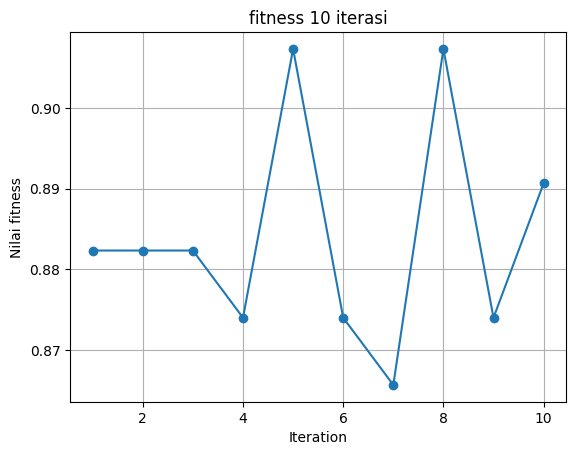

In [31]:
def genetic_algorithm(population_size, chromosome_length, num_generations, num_parents, mutation_rate):
    # Implementasikan algoritma genetika di sini


    return best_solution


# Algoritma genetika
population_size = 190
chromosome_length = 4
num_generations = 10
num_parents = 2
mutation_rate = 0.1


# Inisialisasi daftar kosong untuk menyimpan nilai fitness
fitness_values = []

# Melakukan algoritma genetika sebanyak 10kali
for iteration in range(10):
    best_fitness = 0
    best_solution = []

    for i in range(len(data_a)):
        jumlah_perkamar = data_a['perkamar'][i]
        if data_a['asrama'][i] == 'pniel':
            populasi_chromosome = inisialisasi_populasi_chromosome(data_a['kamar'][i], jumlah_perkamar)
            populasi_chromosome = give_value(data_a, populasi_chromosome, i)
            populasi_chromosome = evaluate_fitness(populasi_chromosome, data_a, i)
            mean_fitness = record_solution(populasi_chromosome, jumlah_perkamar)

            if best_fitness == 0 or mean_fitness[0] > best_fitness:
                temp_fitness = mean_fitness[0]
                best_fitness = temp_fitness
                temp_solution = mean_fitness[1]
                best_solution = temp_solution

            # Seleksi
            populasi_terurut = sorted(populasi_chromosome, key=lambda x: x['nilai_fitness'], reverse=True)
            jumlah_seleksi = 13
            chromosome_terpilih = seleksi(populasi_terurut, jumlah_seleksi)

    print('\n'f"Nilai fitness terbaik setelah iterasi ke-{iteration+1}:", best_fitness)


    # Tambahkan nilai best_fitness ke daftar di setiap iterasi
    fitness_values.append(best_fitness)

# Buat nilai sumbu x (angka iterasi)
iterations = list(range(1, 11))  # 1 to 10

# Plot diagram garis
plt.plot(iterations, fitness_values, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Nilai fitness')
plt.title('fitness 10 iterasi')
plt.grid(True)
plt.show()


In [32]:
# import pickle

# # Definisi fungsi save_model_to_pickle (letakkan di bawah fungsi genetic_algorithm)
# def save_model_to_pickle(model, filename):
#     with open(filename, 'wb') as file:
#         pickle.dump(model, file)
# # Hasil algoritma genetika
# best_solution = genetic_algorithm(population_size, chromosome_length, num_generations, num_parents, mutation_rate)

# # Simpan model_genetika ke dalam file 'model-pniel.pkl'
# save_model_to_pickle(best_solution, 'model-pniel.pkl')
